# B21AI056 Nitish Bhardwaj
# Visual Computing Lab Mini Project 3
# Codebase

# Importing Libraries

In [ ]:
import os
import cv2
import glob
import torch
import random
import datetime
import joblib
import shutil
import tqdm
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from random import randint, uniform
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

## Dataset

In [ ]:
!gdown -O cityscape128.zip "https://drive.google.com/u/0/uc?id=1XUWaL2ijz1vjbKbxJ6TYkG4QZgIsiZu_&export=download"
!unzip cityscape128.zip
# Data path
INPUT_PATH = './segdata128/reduced'
INPUT_PATH_MASK = './segdata128/reduced_mask'

Streaming output truncated to the last 5000 lines.
  inflating: segdata128/reduced_mask/train/1114.jpg  
  inflating: segdata128/reduced_mask/train/294.jpg  
  inflating: segdata128/reduced_mask/train/886.jpg  
  inflating: segdata128/reduced_mask/train/1816.jpg  
  inflating: segdata128/reduced_mask/train/1187.jpg  
  inflating: segdata128/reduced_mask/train/1723.jpg  
  inflating: segdata128/reduced_mask/train/312.jpg  
  inflating: segdata128/reduced_mask/train/2565.jpg  
  inflating: segdata128/reduced_mask/train/1232.jpg  
  inflating: segdata128/reduced_mask/train/2628.jpg  
  inflating: segdata128/reduced_mask/train/2630.jpg  
  inflating: segdata128/reduced_mask/train/2744.jpg  
  inflating: segdata128/reduced_mask/train/1149.jpg  
  inflating: segdata128/reduced_mask/train/1026.jpg  
  inflating: segdata128/reduced_mask/train/1354.jpg  
  inflating: segdata128/reduced_mask/train/989.jpg  
  inflating: segdata128/reduced_mask/train/487.jpg  
  inflating: segdata128/reduced_mask

## Initial Parameters

In [ ]:
INPUT_IMG_SIZE = 128
OUTPUT_CLASSES = 12
LEARINING_RATE = 0.01
OPIMIZER_NAME = 'Adam'
SCHEDULER_NAME = 'stepLR'
BATCH_SIZE = 8
MAX_EPOCHS = 15
AUGMENTATION = False
MEAN = None
STD = None
SCHEDULER_STEP_SIZE = 4
USE_CUDA = torch.cuda.is_available()

## Data preprocessing

In [ ]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
train_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))

print('Total train images:', len(train_files))

print('Total train mask:', len(train_files_mask))

print('Total test images:', len(test_files))
print('Total test mask:', len(test_files_mask))



Total train images: 2975
Total train mask: 2975
Total test images: 500
Total test mask: 500


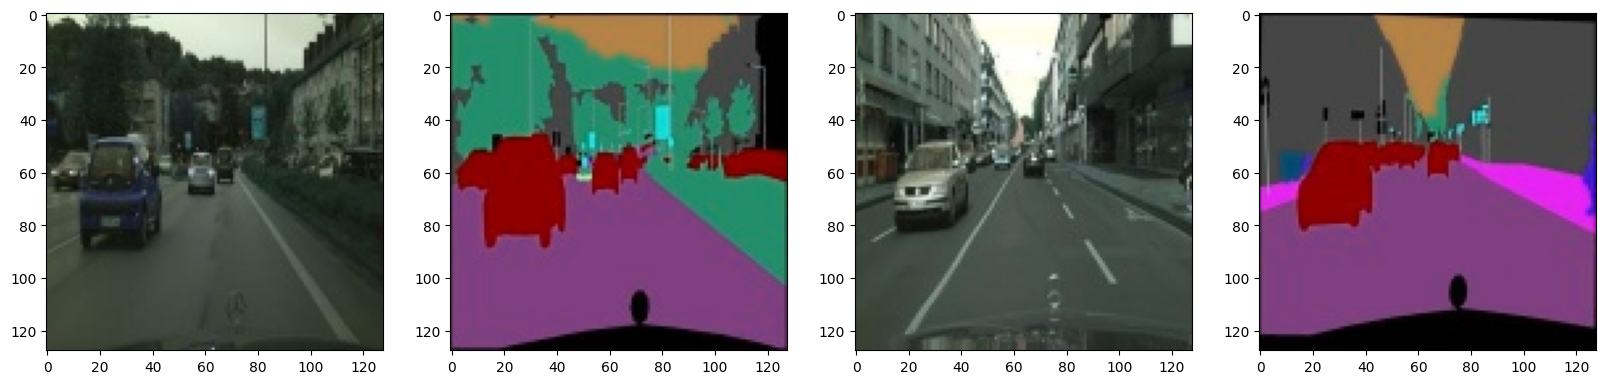

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    if(i%2==0):
      img = cv2.imread(train_files[i//2])
      ax.imshow(img)
    else:
      mk = cv2.imread(train_files_mask[i//2])
      ax.imshow(mk)
    # break
    #ax.axis('off')
plt.show()

## Image color clustering

In [ ]:
kmeans_data = []
for i in train_files_mask[:50]:
    org_img = cv2.imread(i)

    msk = org_img
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
print(kmeans_data.shape)
kmeans_data = kmeans_data.reshape(-1,3)
print(kmeans_data.shape)
# train kmeans with 12 clusters
encoder = KMeans(n_clusters=OUTPUT_CLASSES, n_init=25)
encoder.fit(kmeans_data)
encoder.cluster_centers_

(50, 128, 128, 3)
(819200, 3)


array([[ 68.92369711,  70.03672911,  69.35962155],
       [126.90089894,  64.09376709, 128.39606395],
       [220.80220992,  41.35577188, 233.01787873],
       [ 42.9494444 , 138.46790996, 107.78363224],
       [  6.75534128,   4.46703621,   6.70278244],
       [132.4089384 ,   4.44010485,   5.21344692],
       [167.39827157, 126.02831893,  79.33526195],
       [ 74.76402452,   8.23928917,  81.0736342 ],
       [154.55079385, 152.05780203, 190.70838502],
       [ 64.28459418,  31.36986217, 191.34891271],
       [157.26832386, 242.79332386, 160.76619318],
       [ 45.21967071, 202.22660312, 208.40294627]])

In [ ]:
encoder_filename = '/content/drive/MyDrive/b21ai056_mini_proj_3/kmeans_model.pkl'
joblib.dump(encoder, encoder_filename)

['/content/drive/MyDrive/b21ai056_mini_proj_3/kmeans_model.pkl']

## Image color Encoding

In [ ]:
colors = {0:[ 42.31849768, 138.68802268, 107.34976084],
       1:[127.04043101,  64.08636608, 127.54335584],
       2:[ 67.73835184,  70.81071668,  69.68390725],
       3:[ 77.50990865,  18.95552339,  73.79703489],
       4:[133.96612288,   3.85362098,   4.37284647],
       5:[217.97385828,  43.76697629, 229.43543734],
       6:[164.94309451, 125.22840326,  81.50394562],
       7:[157.10134385, 155.26893603, 193.22678809],
       8:[ 66.53429189,  32.62107138, 188.45387454],
       9:[157.58165138, 243.49941618, 159.97381151],
       10:[  6.98127537,   5.22420501,   6.82420501],
       11:[ 48.88183862, 203.80514614, 203.66699975]
          }

No of classes in encoded mask: [ 0  1  3  4  5  6  7  8 10 11]


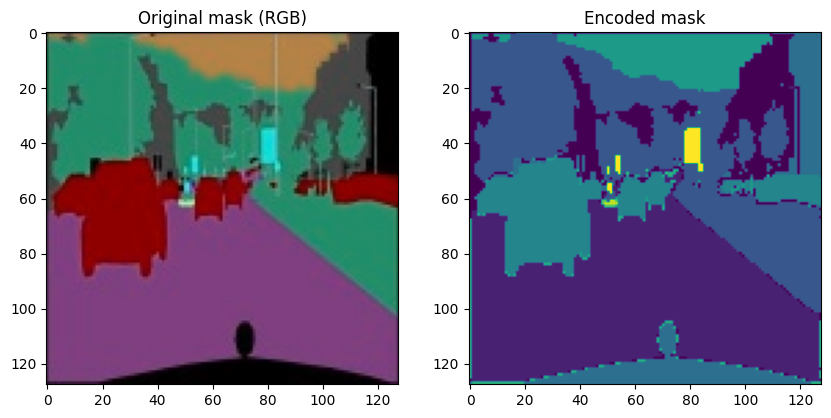

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


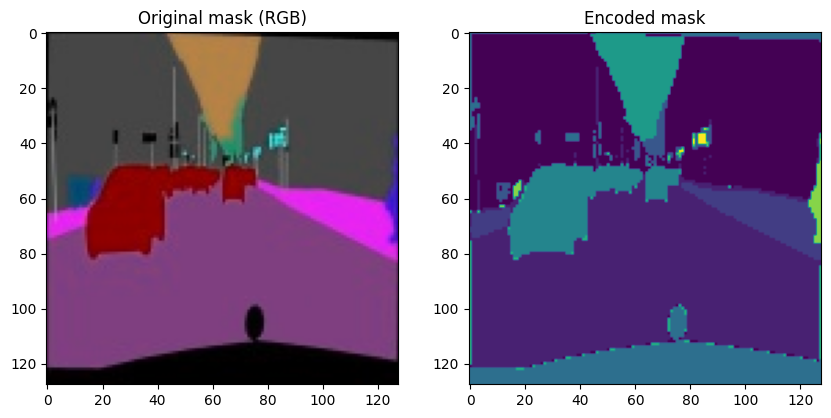

No of classes in encoded mask: [ 0  1  2  3  4  5  6  7  8  9 10 11]


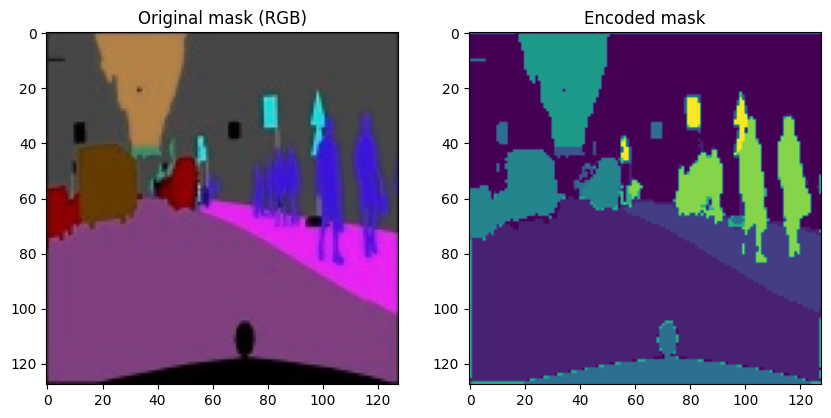

In [ ]:
# encoding with trained kmeans
for i in train_files[:3]:
    org_img = cv2.imread(i)

    msk = cv2.imread(i.replace("reduced","reduced_mask"))
    test = msk.reshape(-1,3)
    pred = encoder.predict(test)

    enc_pred = pred.reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE)

    pred = np.array([colors[p] for p in pred]).reshape(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)

    print('No of classes in encoded mask:',np.unique(enc_pred))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(msk)
    plt.title('Original mask (RGB)')
    plt.subplot(1,2,2)
    plt.imshow(enc_pred)
    plt.title('Encoded mask')
    plt.show()

# Part a

## Load dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, images_list, mask_list, size, augmentation=False, rotation_and_noise = False, apply_noise=False, mean=None, std=None):
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        self.apply_rotation_and_noise = rotation_and_noise
        self.apply_noise = apply_noise

        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def apply_gaussian_noise(self, image, mean=0, stddev=0.1):
        # Generate random Gaussian noise
        noise = np.zeros(image.shape, image.dtype)
        cv2.randn(noise, mean, stddev)

        # Add noise to the image
        noisy_image = cv2.add(image, noise)
        return noisy_image
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')

        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)

        test = (np_target.reshape(-1, 3))
        pred = encoder.predict(test)
        seg_msk = pred.reshape(self.size, self.size)

        if self.apply_rotation_and_noise:
            trans_obj = A.Compose([A.Rotate(limit=(0, 25), p=1)])
            transformed = trans_obj(image=np_image, mask=seg_msk)
            transformed['image'] = self.apply_gaussian_noise(transformed['image'], stddev=25.5)
            norm1 = A.Compose([A.Normalize(self.mean, self.std)])
            transformed = norm1(image=transformed['image'],mask=seg_msk )
        elif self.augmentation and self.apply_noise:
            trans_obj = A.Compose([
                A.Resize(self.size, self.size),
                A.Rotate(limit=(0, 25), p=1),
                A.Normalize(self.mean, self.std)
            ])
            transformed = trans_obj(image=np_image, mask=seg_msk)
            transformed['image'] = self.apply_gaussian_noise(transformed['image'])

        else:
            trans_obj = A.Compose([
                A.Resize(self.size, self.size),
                A.Normalize(self.mean, self.std)
            ])
            transformed = trans_obj(image=np_image, mask=seg_msk)


        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


## Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)

        contracting_31_out = self.contracting_31(contracting_22_out)

        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))

        expansive_31_out = self.expansive_31(expansive_22_out)

        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out

In [ ]:
nt = Net(12)

In [ ]:
nt(torch.zeros(2,3,128,128)).shape

torch.Size([2, 12, 128, 128])

## Trainer

In [ ]:
class Trainer:
    def __init__(self,
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,                # Validation (or test) data set
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 experiment_name = None,
                 step_size = None,
                 path_to_save=None
                 ):
        self.model = model
        self.model_path=path_to_save
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.step_size = step_size

        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)

        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)


    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)

    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)

    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []

        for i, (images, labels) in enumerate(self.train_dl):
            batchsize = images.shape[0]
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds)
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item()
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)

        loss_avg = np.mean(loss_list)
        acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy = self.IoU(labels, preds)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}]'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy))

    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.title('loss')
        plt.show()

    def train(self):

        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []

        for epoch_counter in tqdm.tqdm(range(1, self.max_epochs+1)):
            train_loss, train_accuracy = self.train_epoch()
            val_loss, val_accuracy= self.val_epoch(epoch_counter)
            epoch_counter_list.append(epoch_counter)
            train_loss_list.append(train_loss)
            train_accuracy_list.append(train_accuracy)
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy]
            self.print_train_logs(epoch_results)

            if val_accuracy == max(val_accuracy_list) and self.model_path != None:
              torch.save(self.model.state_dict(), self.model_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list]
        self.plot_logs(train_results)

## Validator

In [ ]:
import torch

class Validator:
    def __init__(self, model, val_data, criterion, use_cuda=False):
        self.model = model
        self.val_data = val_data
        self.criterion = criterion
        self.cuda = use_cuda

        if use_cuda:
            self.model = model.cuda()

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size=8, shuffle=False)  # Batch size 1 for validation


    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)

        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def validate(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        acc_list = []

        with torch.no_grad():
            val_dl = self.data_loader(self.val_data)

            for i, (images, labels) in enumerate(val_dl):
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                accuracy = self.IoU(labels, preds)
                acc_list.append(accuracy)

        acc_avg = np.mean(acc_list)
        return acc_avg



## Create dataset objects

In [ ]:
train_data_obj = Dataset(train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [ ]:
print(train_data_obj.__len__())
print(val_data_obj.__len__())

2975
500


## Data visualization

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9647) tensor(0.0196)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


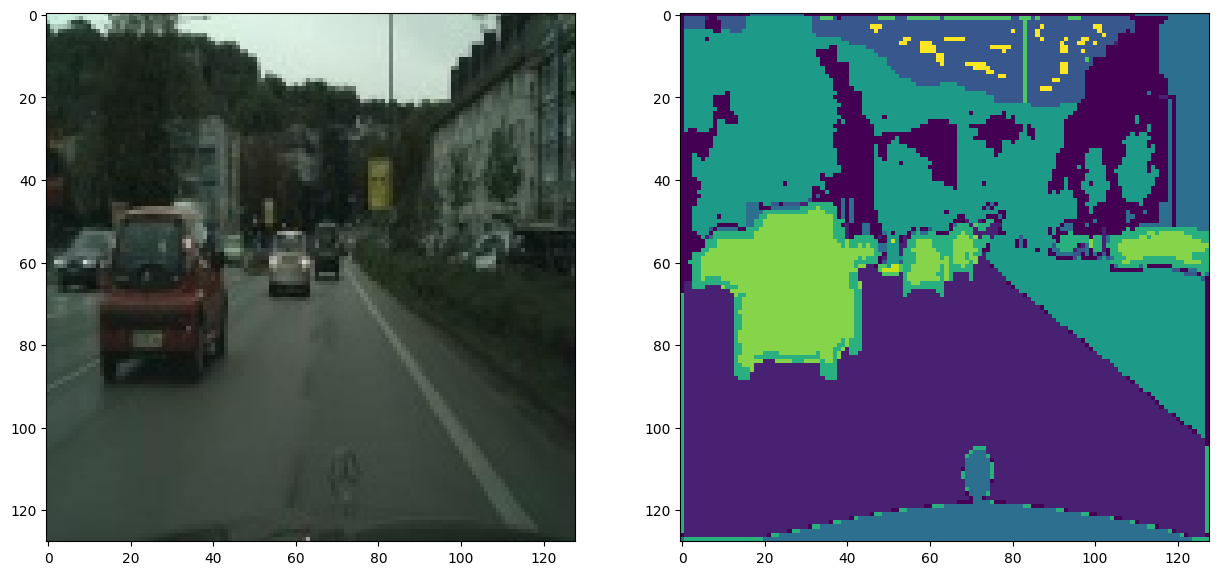

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


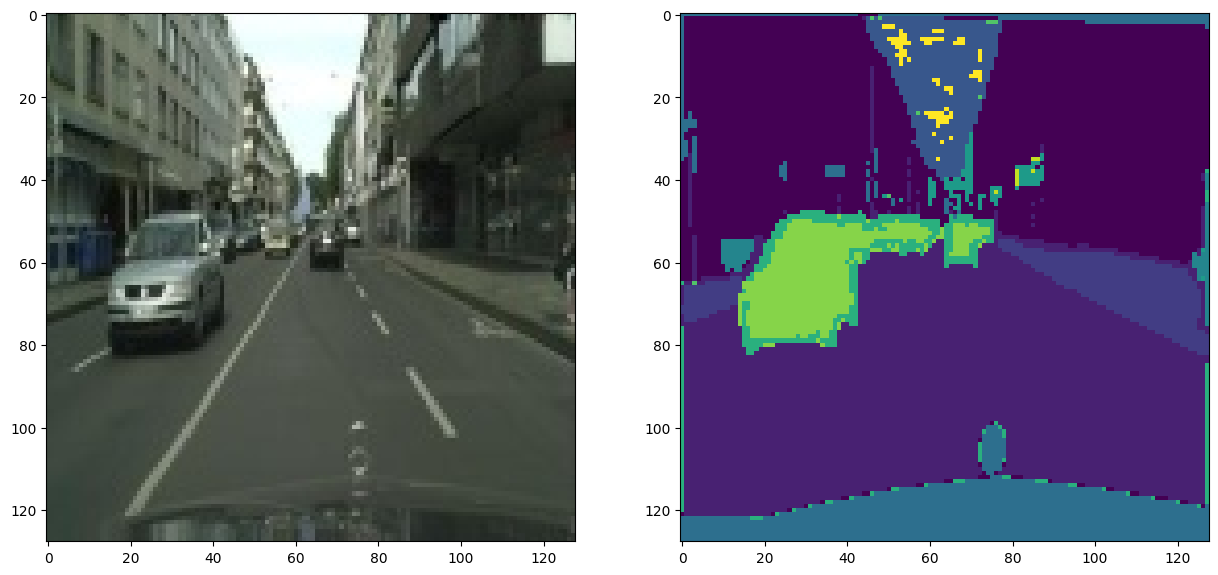

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0039)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


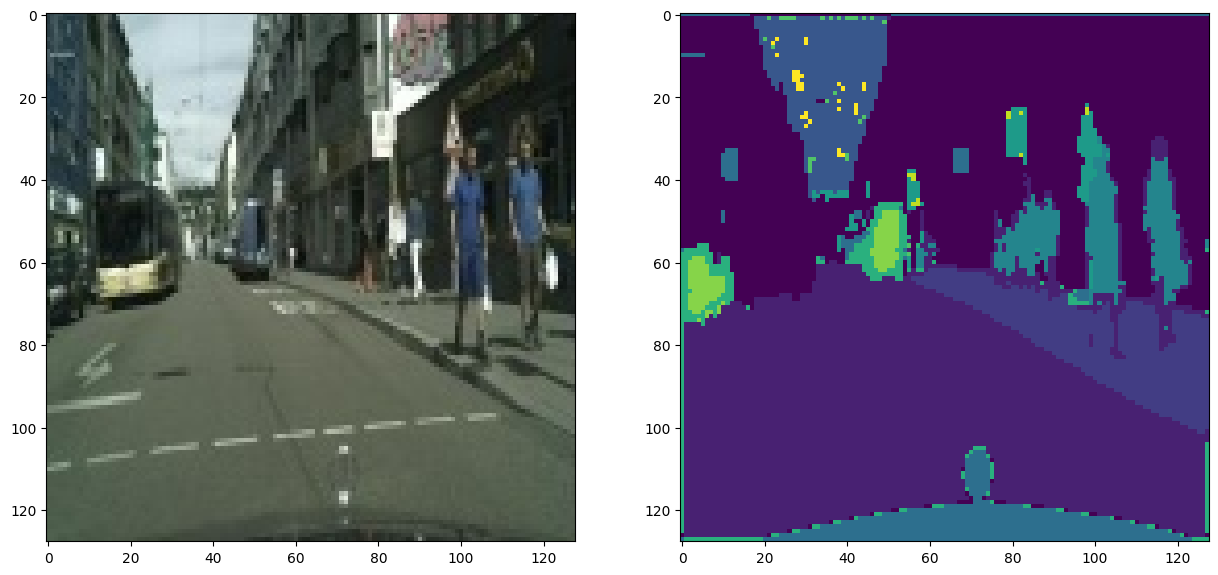

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0078)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


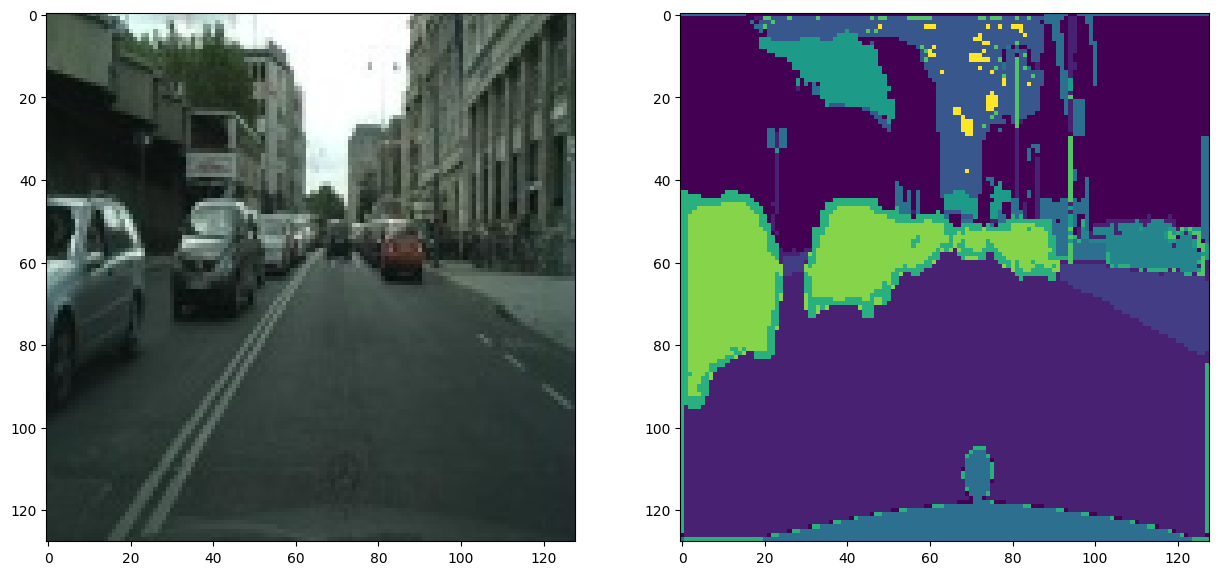

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0275)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


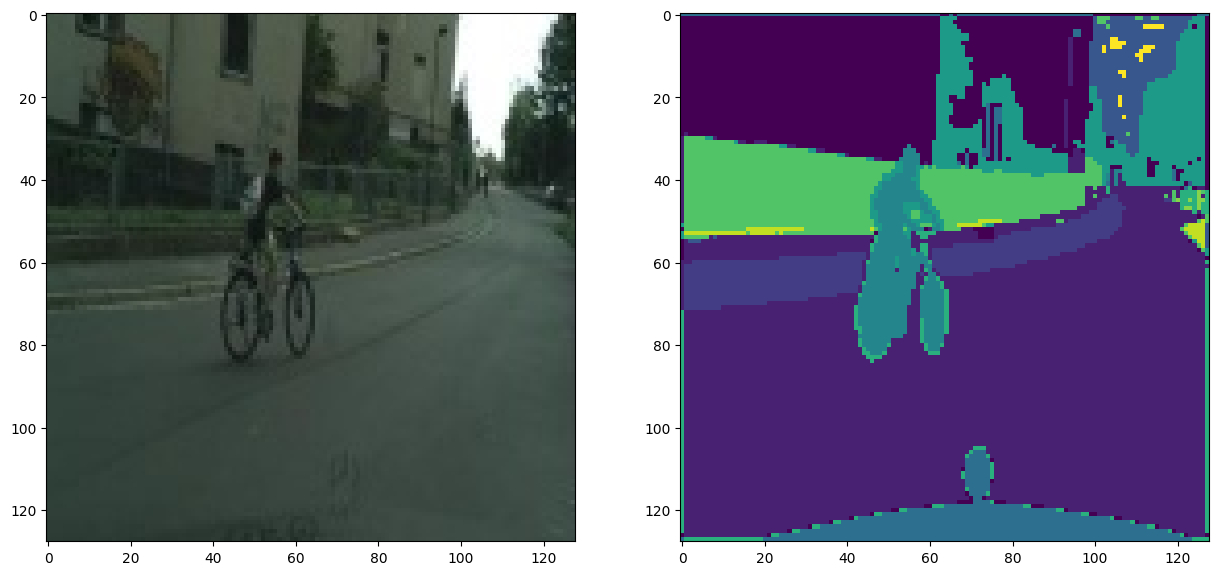

In [ ]:
for i in range(5):
    img,  msk = train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Define models

In [ ]:
unet = Net(num_classes=OUTPUT_CLASSES)

## No of trainable parameters

In [ ]:
print(sum(p.numel() for p in unet.parameters()))

18010252


## Define loss function

In [ ]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_obj,
                  val_data = val_data_obj,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  step_size = SCHEDULER_STEP_SIZE,
                  path_to_save = "/content/drive/MyDrive/b21ai056_mini_proj_3/initial_model"
                 )

## Start training

  0%|          | 0/15 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


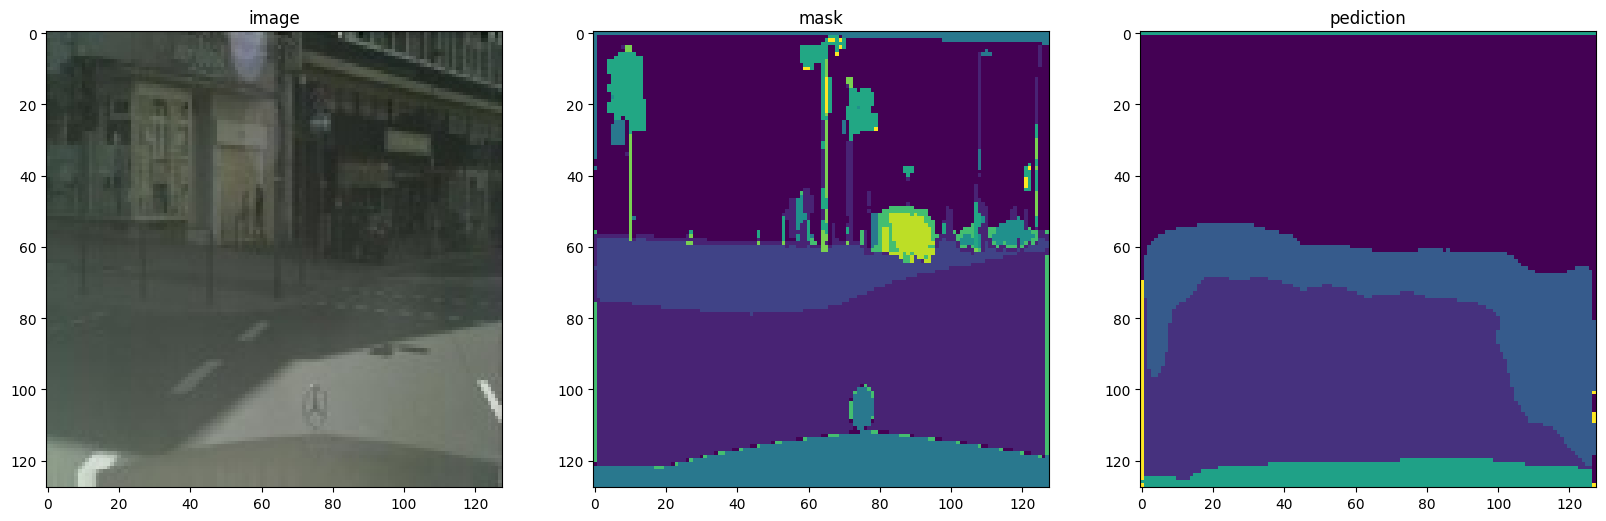

[Epochs-1/15]:
[Train_loss:1.1332 | Train_acc:0.2618 | Val_loss:1.2397 | Val_acc:0.2426]


  7%|▋         | 1/15 [01:23<19:33, 83.79s/it]

--------------------
Validation results after 2 epochs:


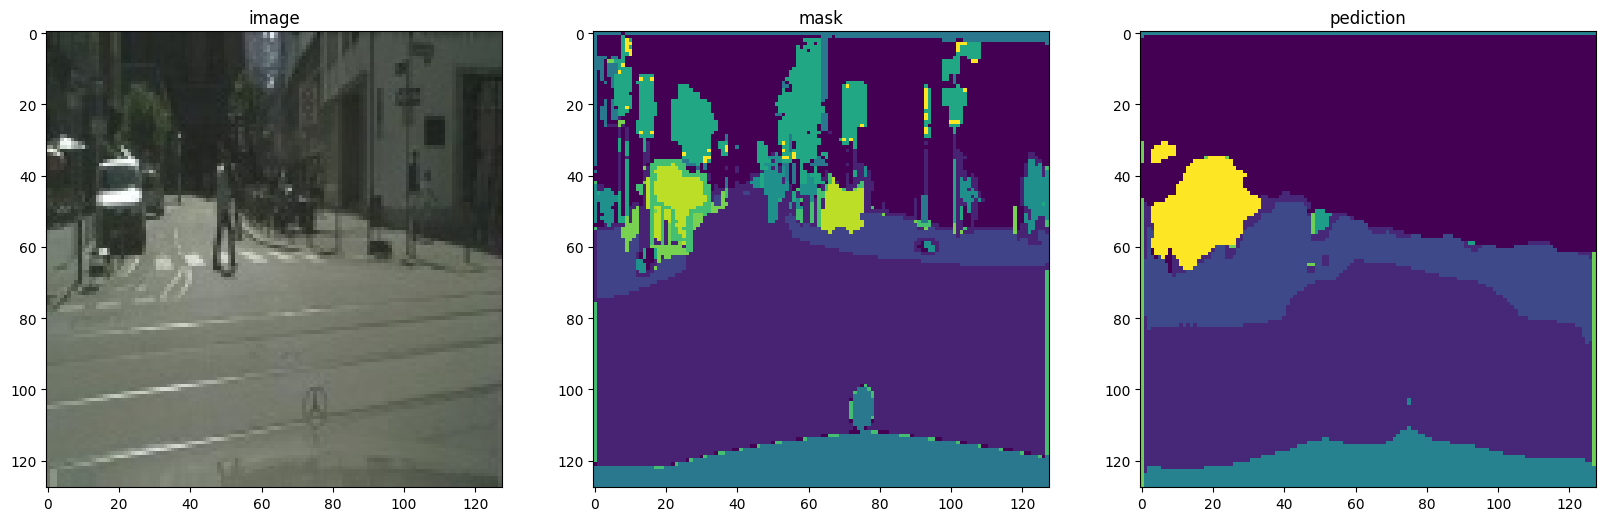

 13%|█▎        | 2/15 [02:39<17:10, 79.25s/it]

[Epochs-2/15]:
[Train_loss:0.8481 | Train_acc:0.3530 | Val_loss:0.8882 | Val_acc:0.3435]
--------------------
Validation results after 3 epochs:


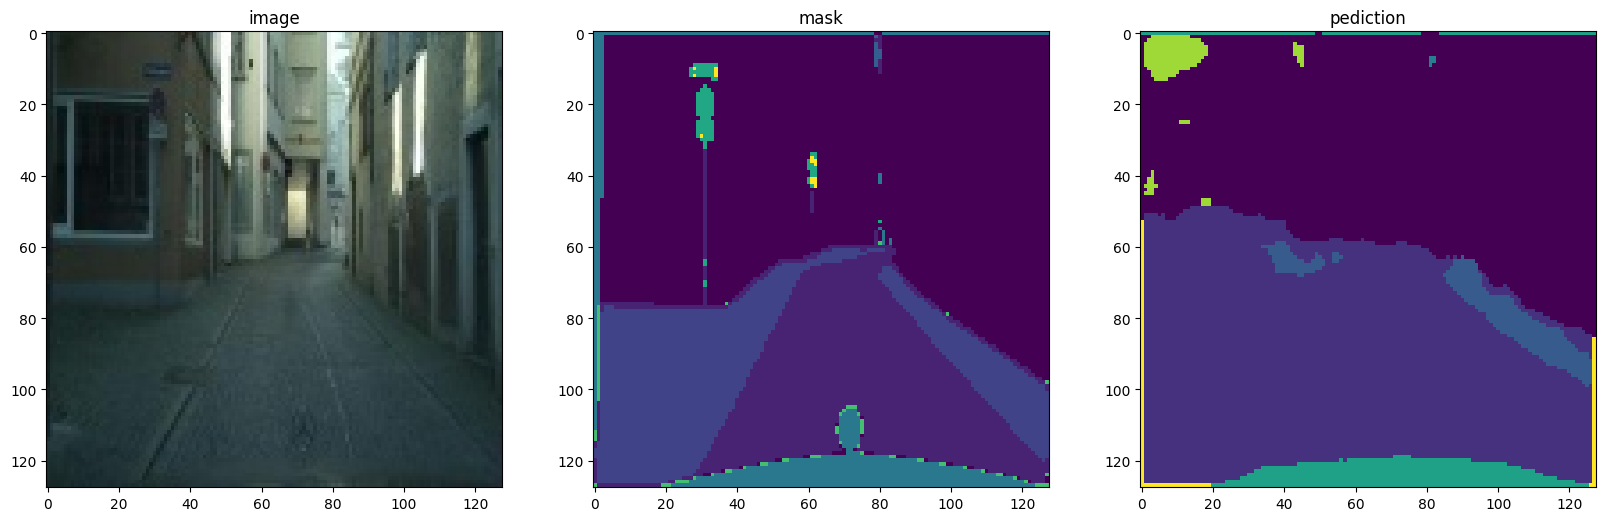

[Epochs-3/15]:
[Train_loss:0.7408 | Train_acc:0.3999 | Val_loss:0.8346 | Val_acc:0.3474]


 20%|██        | 3/15 [03:55<15:32, 77.73s/it]

--------------------
Validation results after 4 epochs:


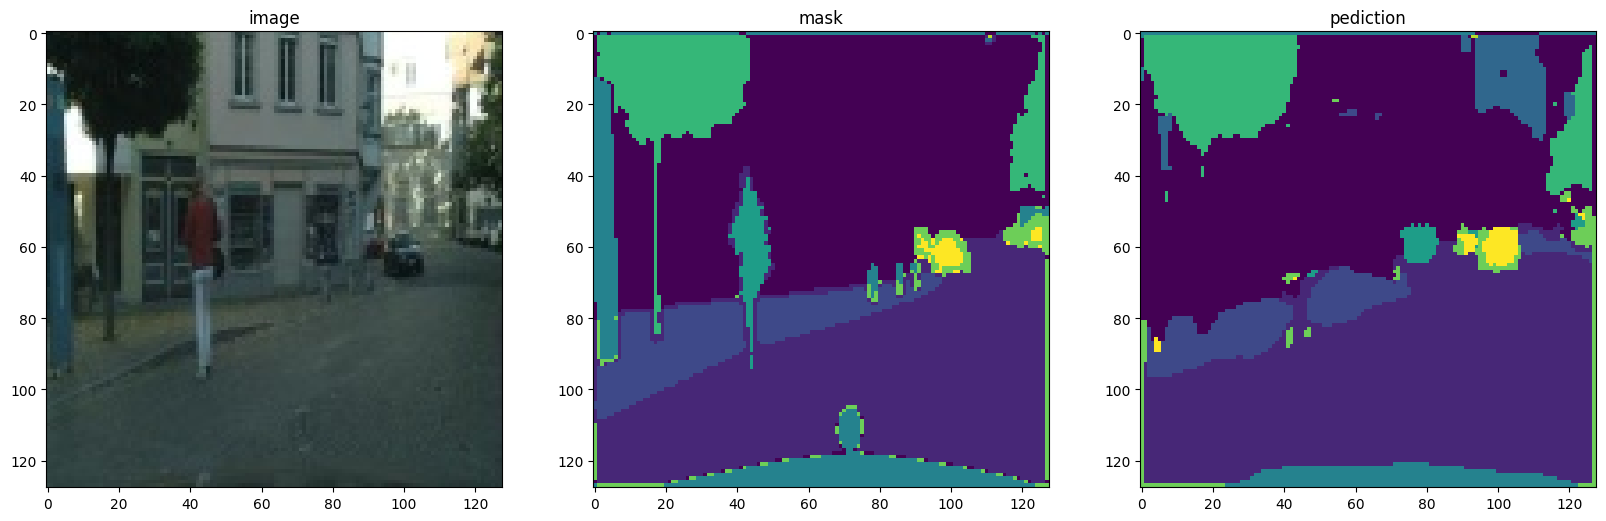

[Epochs-4/15]:
[Train_loss:0.6800 | Train_acc:0.4291 | Val_loss:0.7394 | Val_acc:0.4026]


 27%|██▋       | 4/15 [05:12<14:09, 77.25s/it]

--------------------
Validation results after 5 epochs:


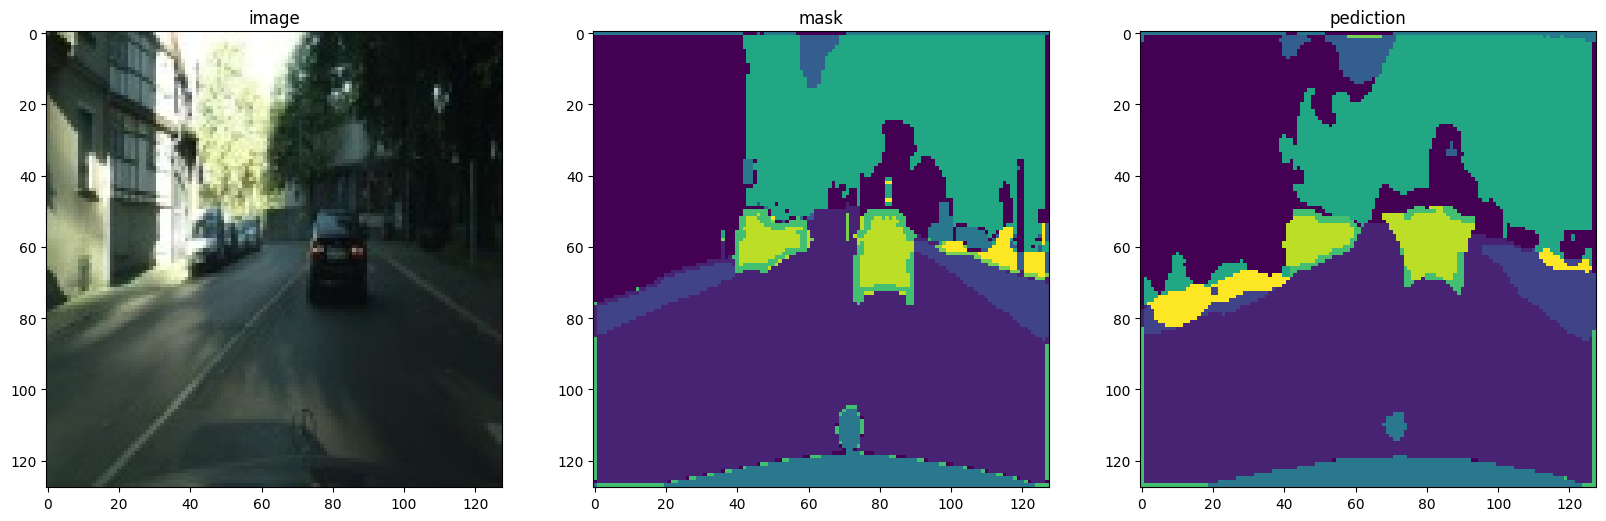

[Epochs-5/15]:
[Train_loss:0.5972 | Train_acc:0.4663 | Val_loss:0.6029 | Val_acc:0.4541]


 33%|███▎      | 5/15 [06:28<12:50, 77.04s/it]

--------------------
Validation results after 6 epochs:


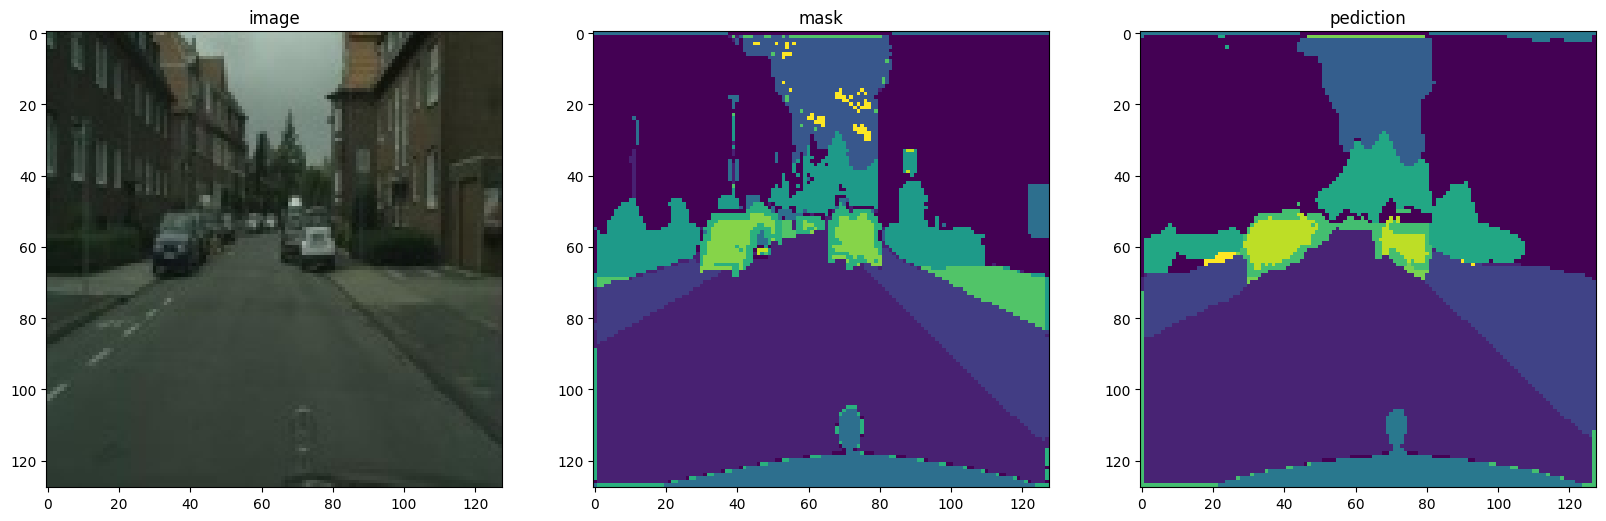

[Epochs-6/15]:
[Train_loss:0.5774 | Train_acc:0.4757 | Val_loss:0.5853 | Val_acc:0.4622]


 40%|████      | 6/15 [07:44<11:29, 76.65s/it]

--------------------
Validation results after 7 epochs:


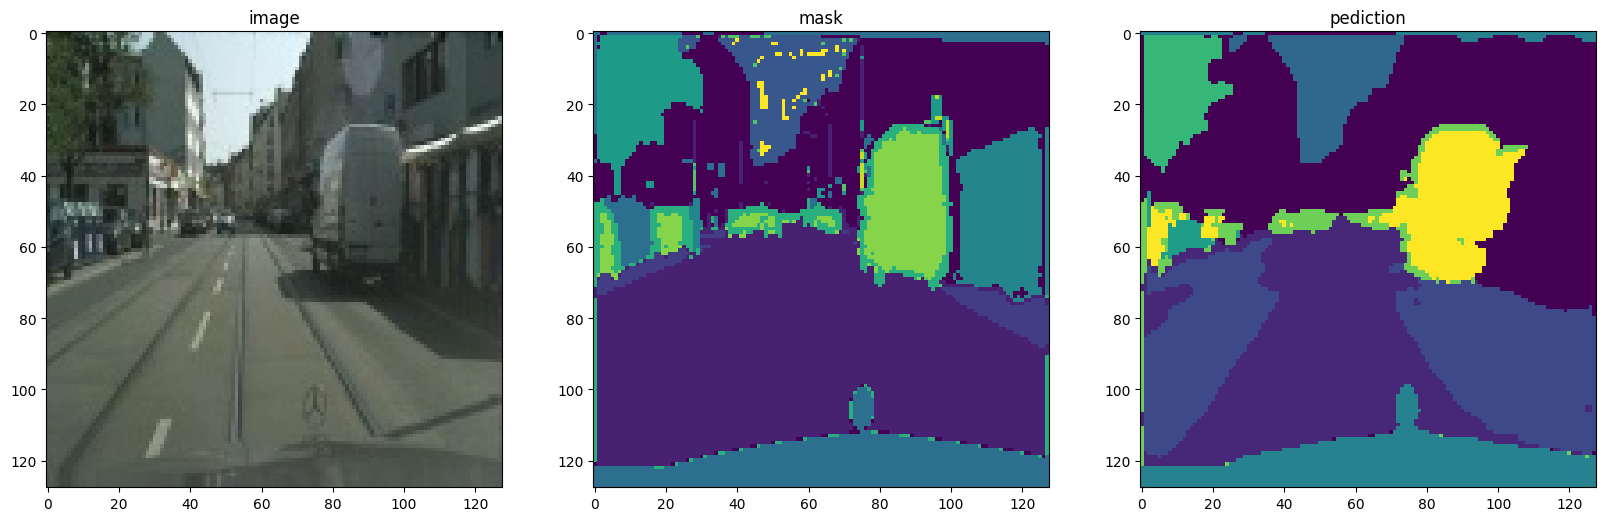

[Epochs-7/15]:
[Train_loss:0.5662 | Train_acc:0.4821 | Val_loss:0.5886 | Val_acc:0.4642]


 47%|████▋     | 7/15 [09:02<10:14, 76.85s/it]

--------------------
Validation results after 8 epochs:


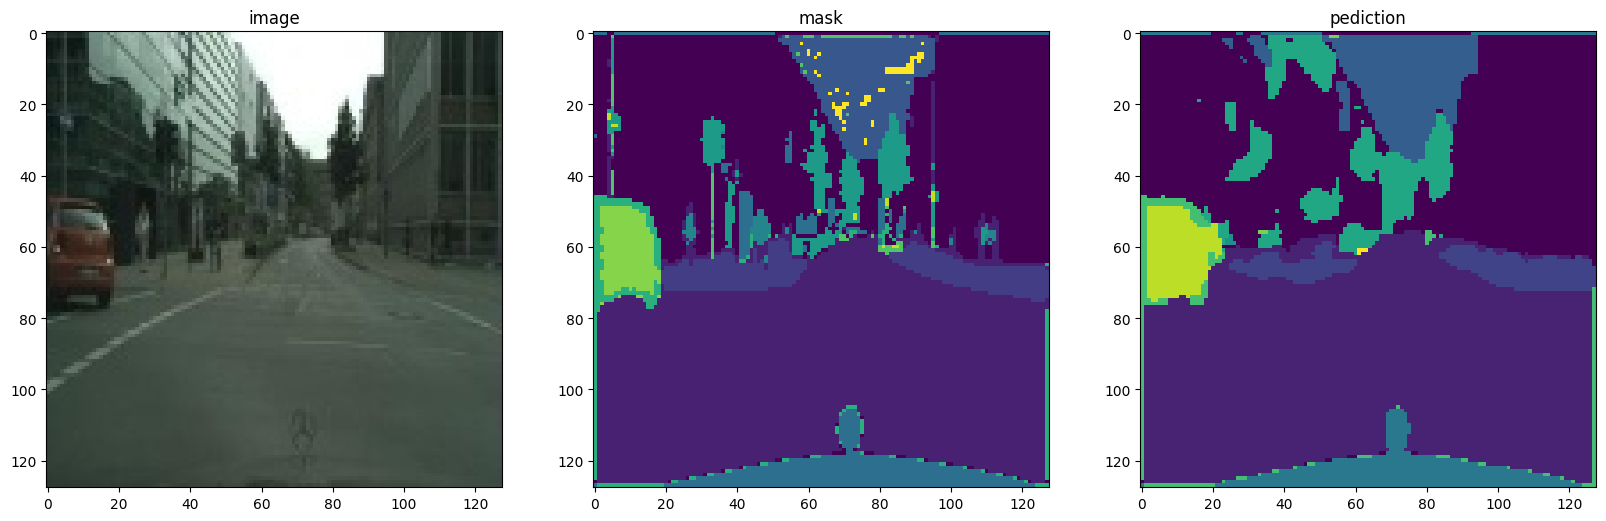

[Epochs-8/15]:
[Train_loss:0.5547 | Train_acc:0.4875 | Val_loss:0.5684 | Val_acc:0.4661]


 53%|█████▎    | 8/15 [10:17<08:55, 76.52s/it]

--------------------
Validation results after 9 epochs:


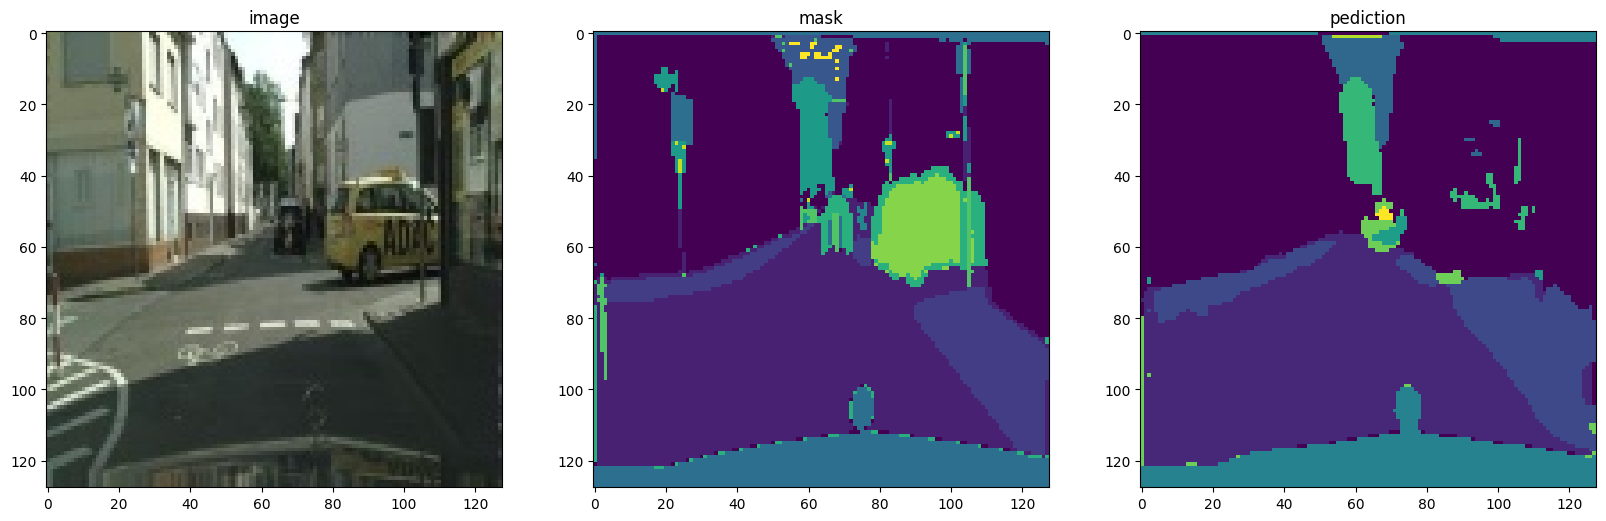

[Epochs-9/15]:
[Train_loss:0.5328 | Train_acc:0.4978 | Val_loss:0.5605 | Val_acc:0.4725]


 60%|██████    | 9/15 [11:35<07:40, 76.70s/it]

--------------------
Validation results after 10 epochs:


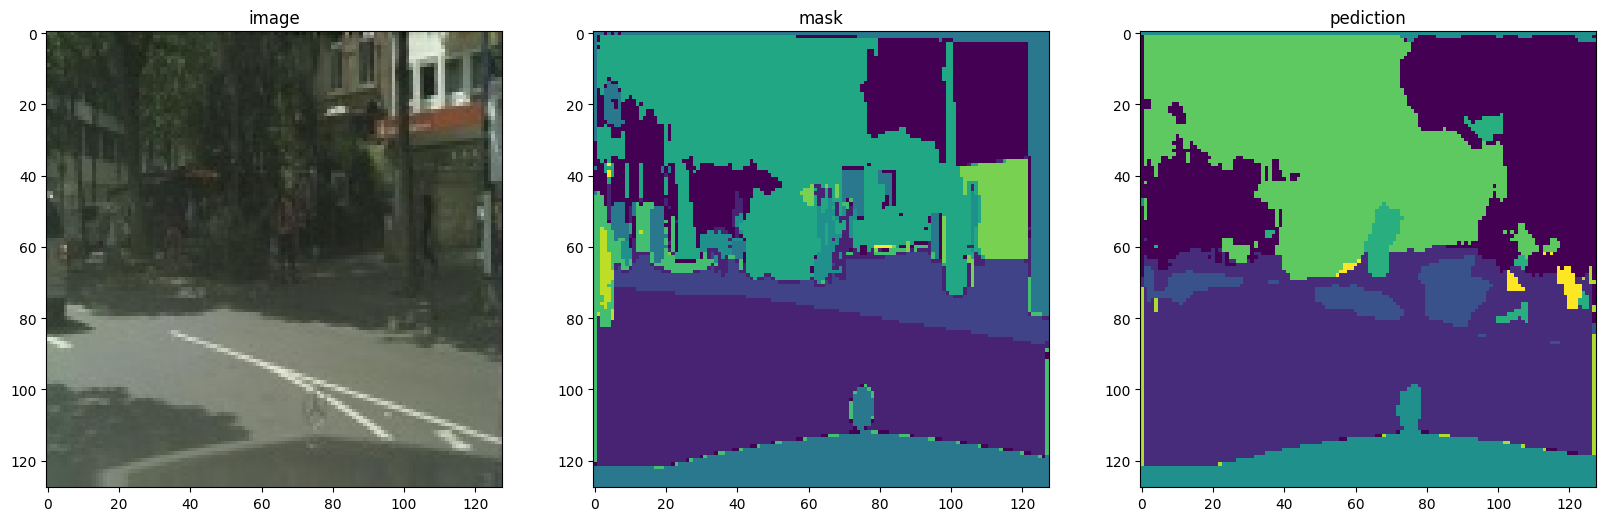

 67%|██████▋   | 10/15 [12:50<06:21, 76.36s/it]

[Epochs-10/15]:
[Train_loss:0.5291 | Train_acc:0.4993 | Val_loss:0.5608 | Val_acc:0.4715]
--------------------
Validation results after 11 epochs:


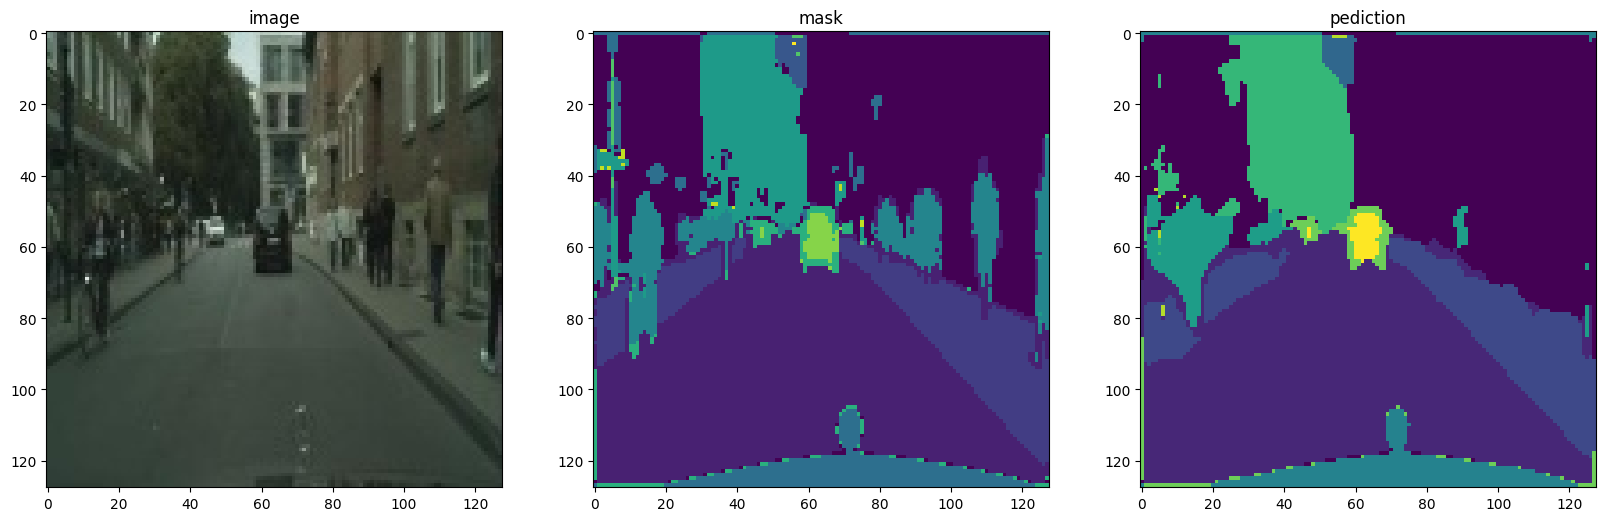

[Epochs-11/15]:
[Train_loss:0.5279 | Train_acc:0.4994 | Val_loss:0.5602 | Val_acc:0.4752]


 73%|███████▎  | 11/15 [14:08<05:07, 76.83s/it]

--------------------
Validation results after 12 epochs:


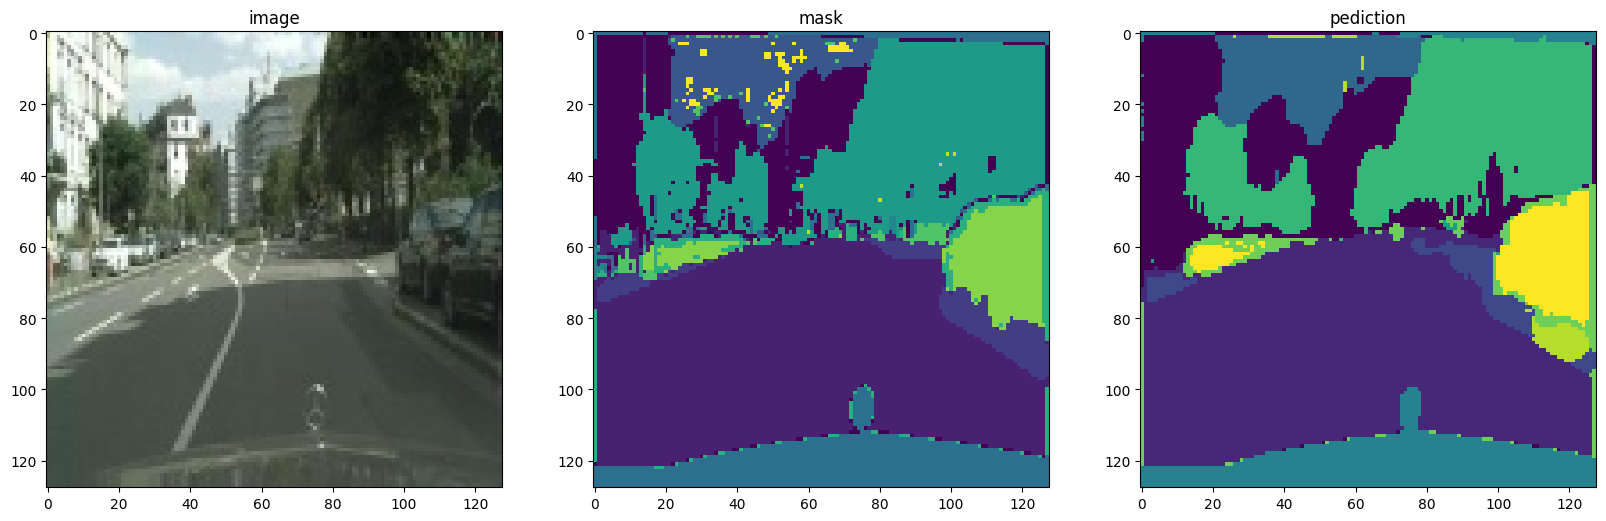

 80%|████████  | 12/15 [15:24<03:49, 76.55s/it]

[Epochs-12/15]:
[Train_loss:0.5261 | Train_acc:0.5008 | Val_loss:0.5620 | Val_acc:0.4726]
--------------------
Validation results after 13 epochs:


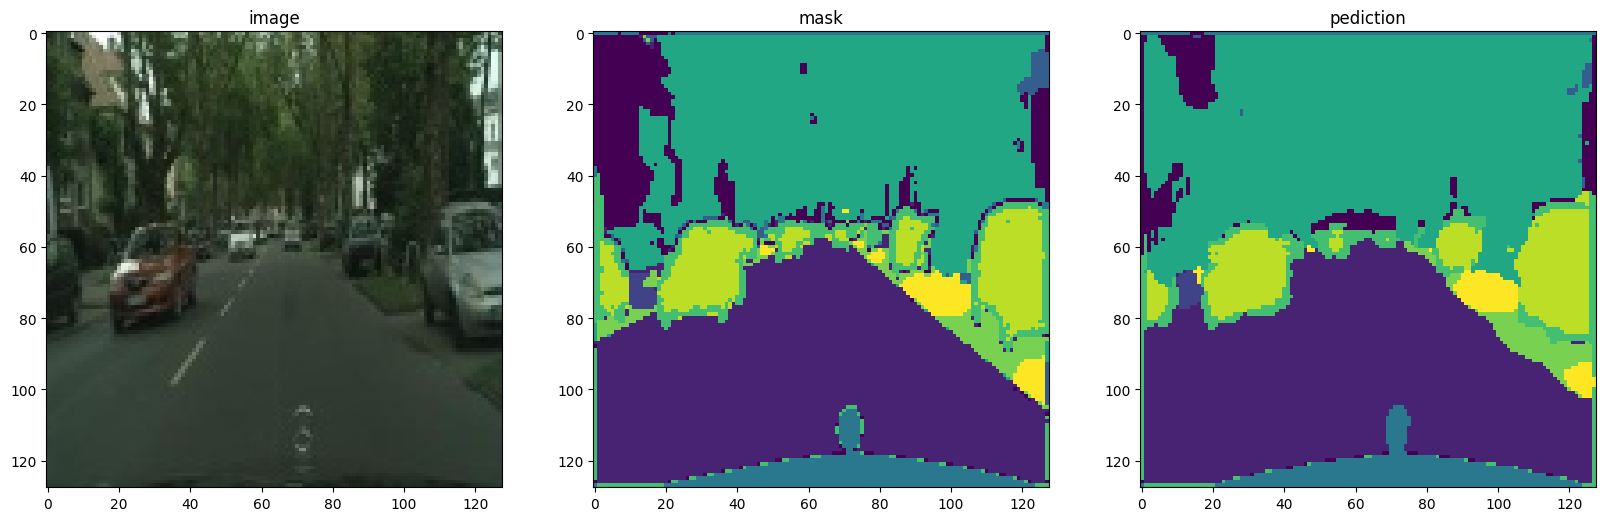

 87%|████████▋ | 13/15 [16:41<02:33, 76.68s/it]

[Epochs-13/15]:
[Train_loss:0.5237 | Train_acc:0.5026 | Val_loss:0.5585 | Val_acc:0.4748]
--------------------
Validation results after 14 epochs:


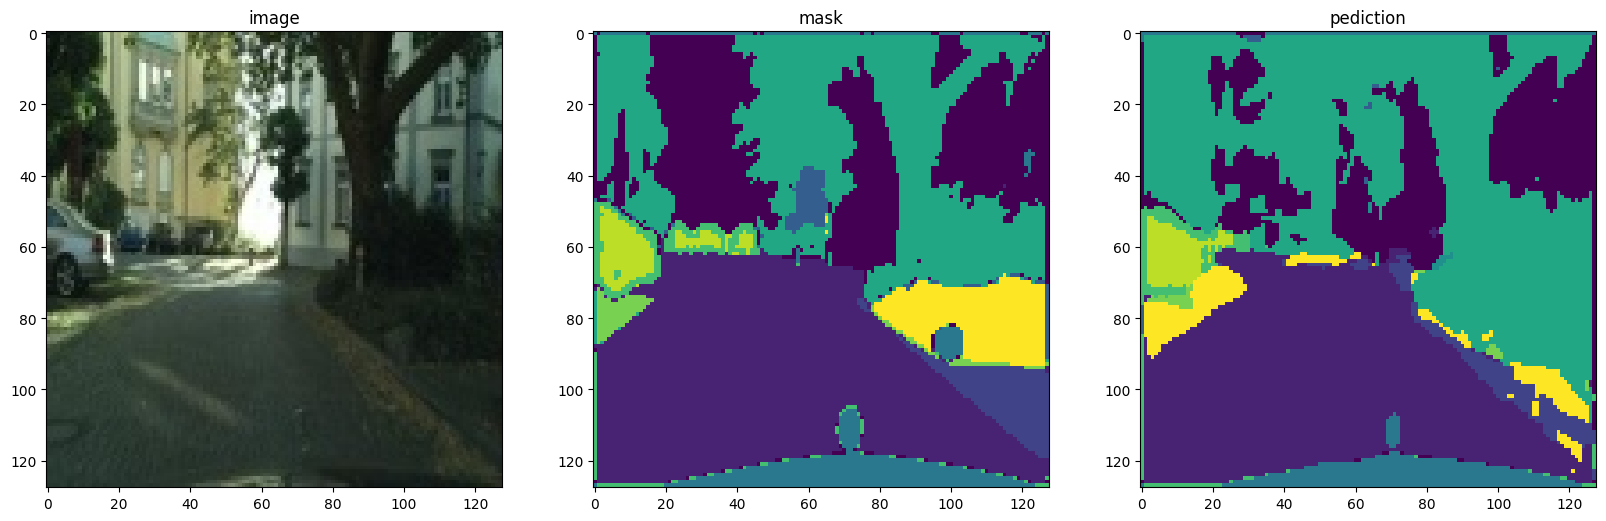

[Epochs-14/15]:
[Train_loss:0.5218 | Train_acc:0.5027 | Val_loss:0.5588 | Val_acc:0.4774]


 93%|█████████▎| 14/15 [17:57<01:16, 76.55s/it]

--------------------
Validation results after 15 epochs:


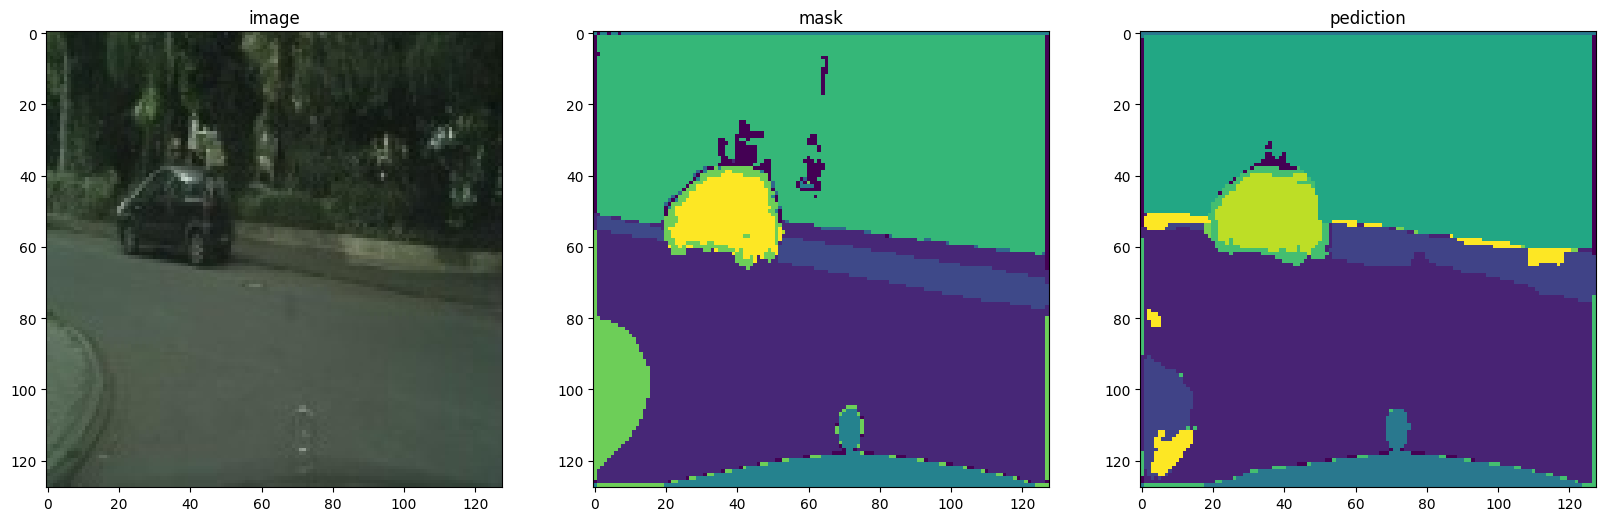

100%|██████████| 15/15 [19:14<00:00, 76.93s/it]

[Epochs-15/15]:
[Train_loss:0.5220 | Train_acc:0.5031 | Val_loss:0.5581 | Val_acc:0.4747]


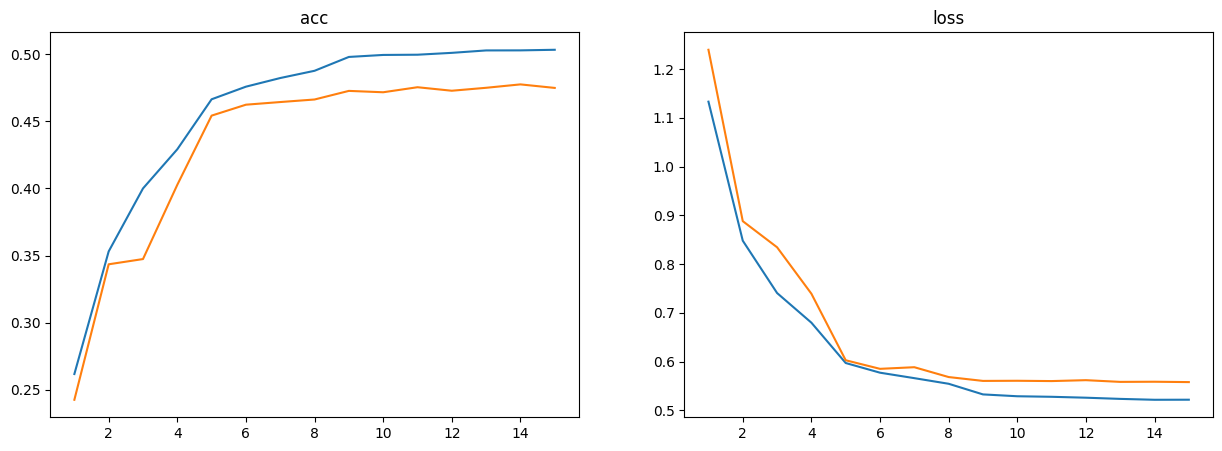

In [ ]:
trainer.train()

## Save the model

In [ ]:
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/b21ai056_mini_proj_3/Model_1.pth")

## Testing Model1 on regular dataset as well as on modified dataset

In [ ]:
# Create an instance of your model1 class
model1 = Net(num_classes=OUTPUT_CLASSES)

# Load the model1 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_1.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model1
model1.load_state_dict(new_state_dict)

# Set the model1 to evaluation mode
model1.eval()

validator = Validator(model1, val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)


Validation Accuracy: 0.4763727666269016


# Part b

In [ ]:
new_val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)
validator = Validator(model1, new_val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.25680903097951274


## Create modified dataset objects

In [ ]:
new_train_data_obj =  Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)
new_val_data_obj =  Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)

In [ ]:
print(new_train_data_obj.__len__())
print(new_val_data_obj.__len__())

500
500


## Data visualization

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.2572) tensor(-0.2464)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


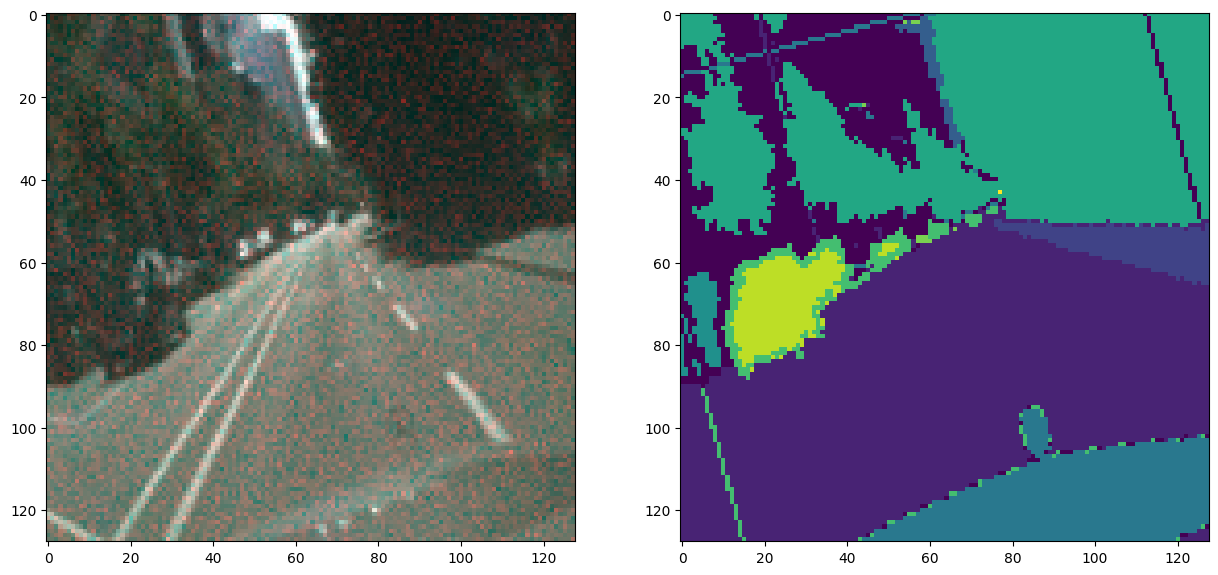

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.1062) tensor(-0.2447)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


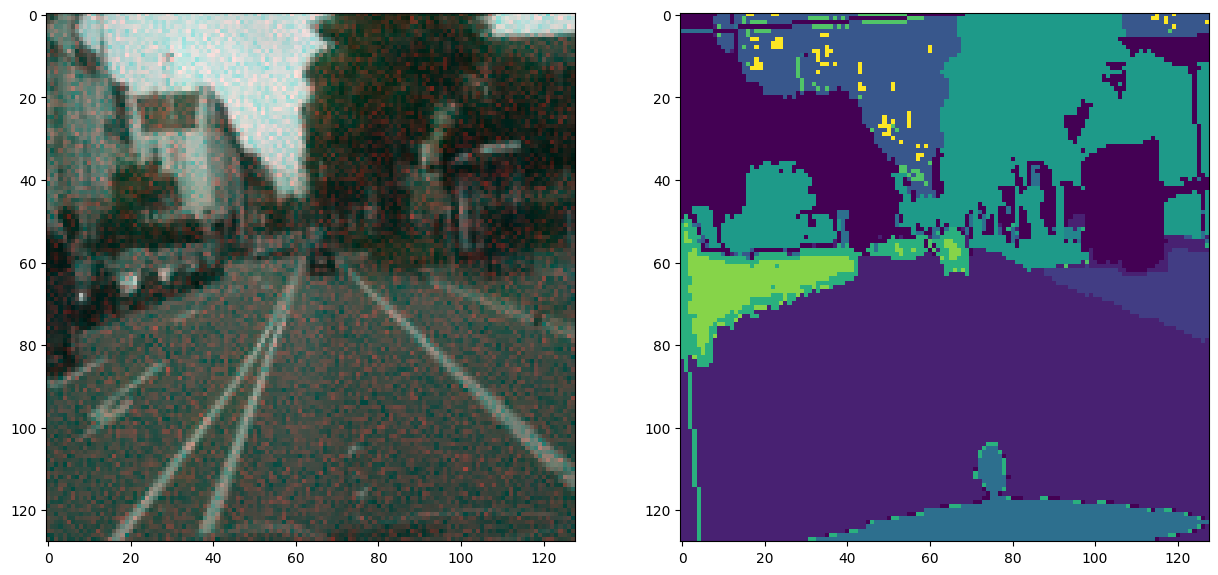

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.1177) tensor(-0.3406)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


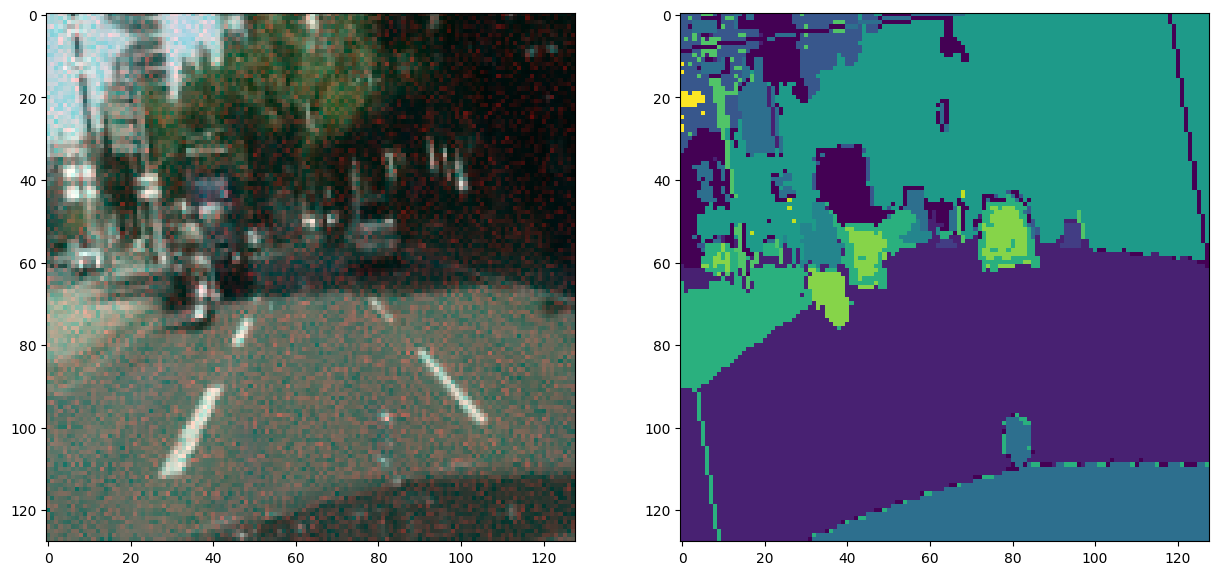

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.0412) tensor(-0.2995)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


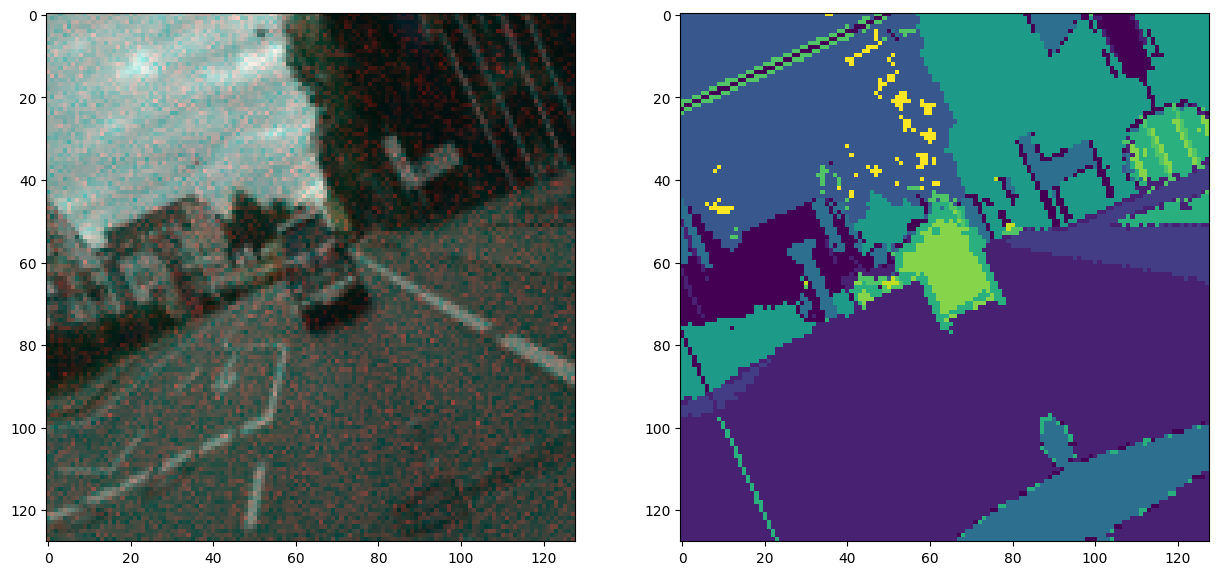

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.3216) tensor(-0.2404)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


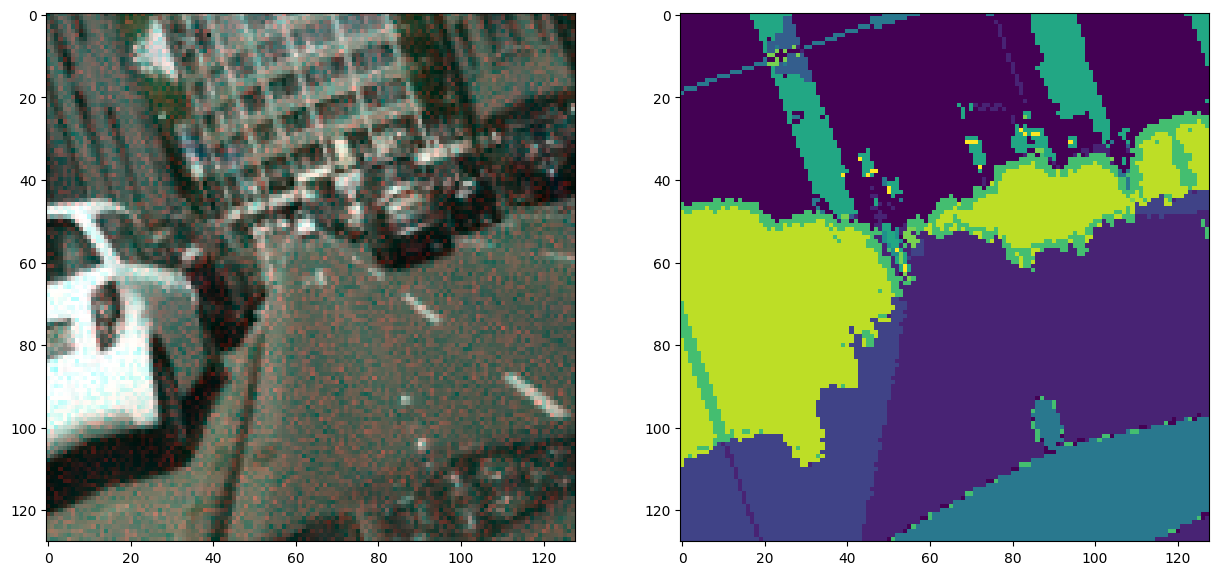

In [ ]:
for i in range(5):
    img,  msk = new_train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

-------------------------------------------Modified model to be trained on modified dataset1------------------------------------

## Define models

In [ ]:
unet = Net(num_classes=OUTPUT_CLASSES)

## No of trainable parameters

In [ ]:
print(sum(p.numel() for p in unet.parameters()))

18010252


## Define loss function

In [ ]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = new_train_data_obj,
                  val_data = new_val_data_obj,
                  opti_name = 'SGD',
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE//2,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  step_size = SCHEDULER_STEP_SIZE,
                  path_to_save = "/content/drive/MyDrive/b21ai056_mini_proj_3/Final_model"
                 )

## Start training

  0%|          | 0/15 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 1 epochs:


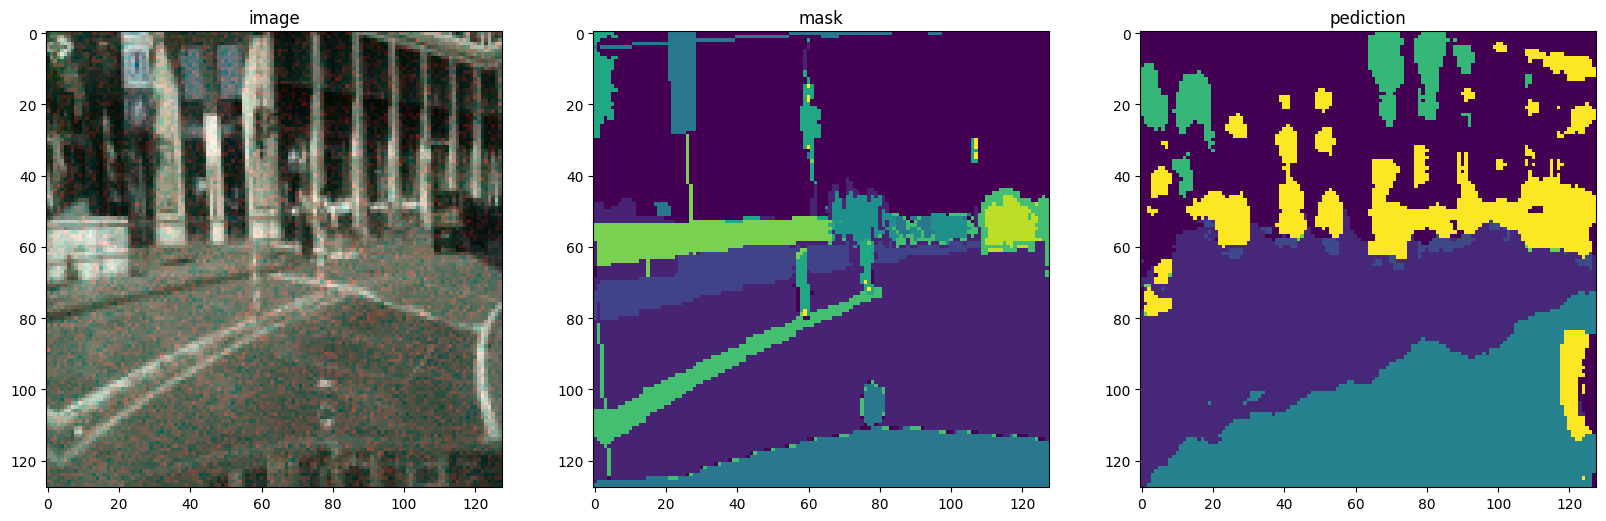

  7%|▋         | 1/15 [00:21<04:59, 21.43s/it]

[Epochs-1/15]:
[Train_loss:1.4101 | Train_acc:0.1786 | Val_loss:1.3775 | Val_acc:0.1817]


--------------------
Validation results after 2 epochs:


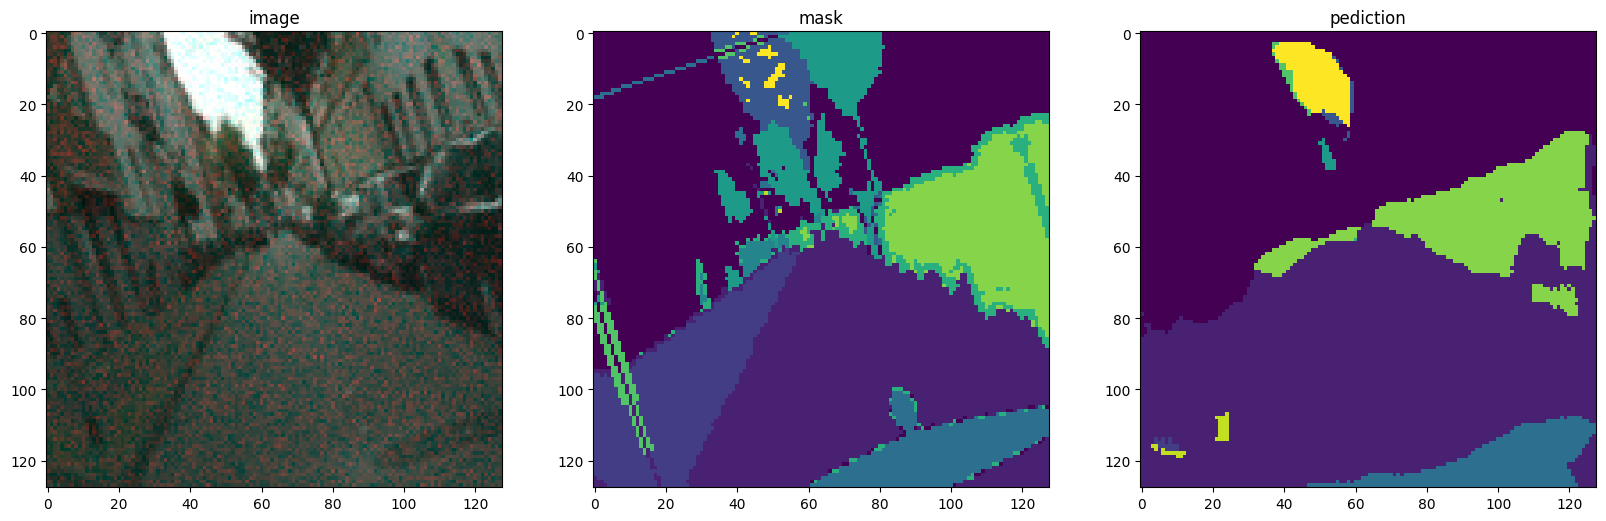

[Epochs-2/15]:
[Train_loss:1.0232 | Train_acc:0.2643 | Val_loss:1.0413 | Val_acc:0.2300]


 13%|█▎        | 2/15 [00:41<04:27, 20.56s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 3 epochs:


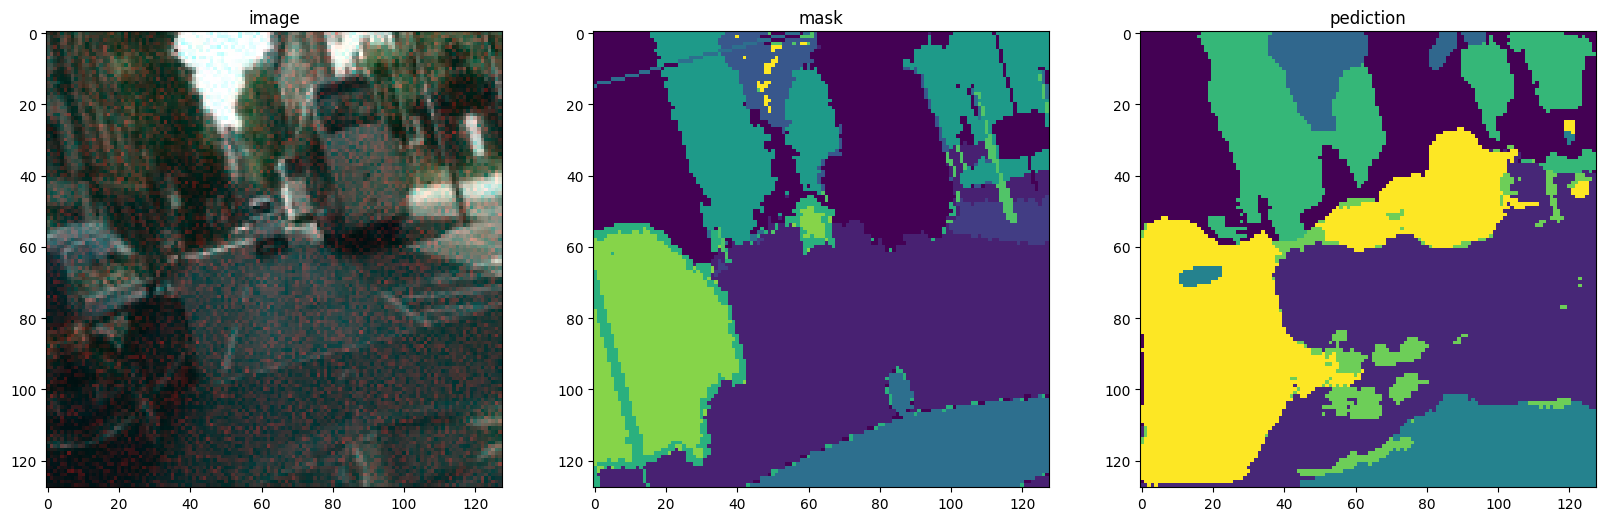

[Epochs-3/15]:
[Train_loss:0.9377 | Train_acc:0.2967 | Val_loss:0.9549 | Val_acc:0.3012]


 20%|██        | 3/15 [01:02<04:11, 20.99s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 4 epochs:


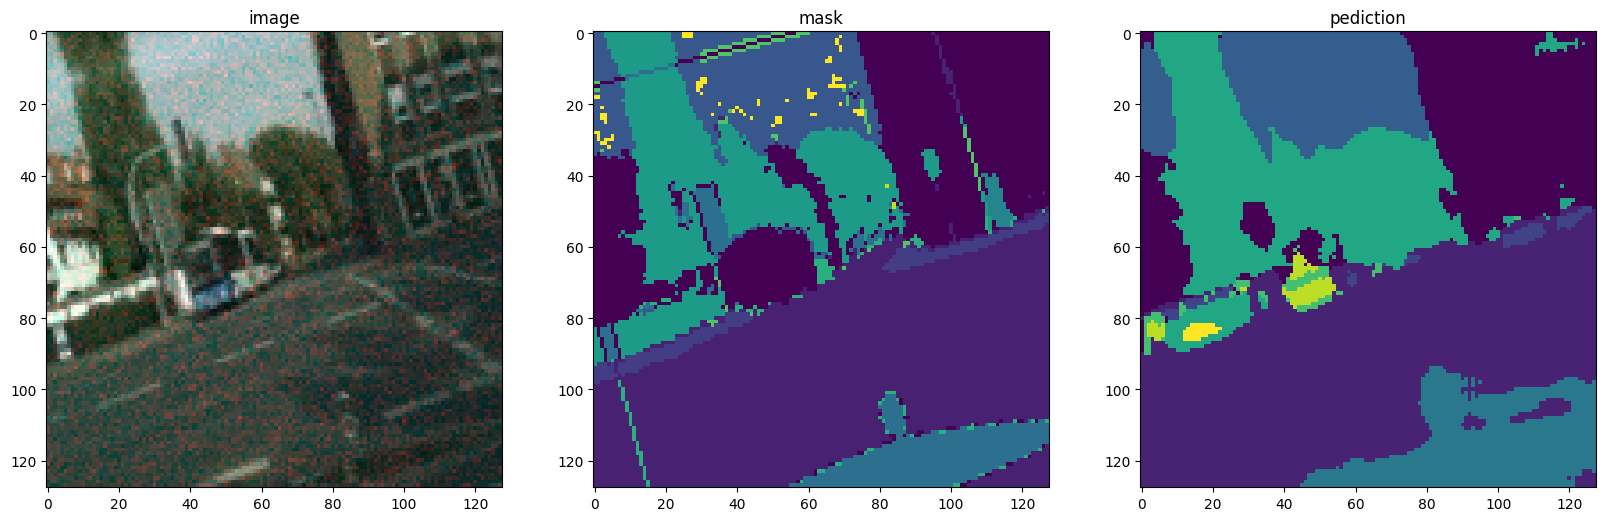

 27%|██▋       | 4/15 [01:22<03:46, 20.57s/it]

[Epochs-4/15]:
[Train_loss:0.8906 | Train_acc:0.3190 | Val_loss:0.8494 | Val_acc:0.3250]


--------------------
Validation results after 5 epochs:


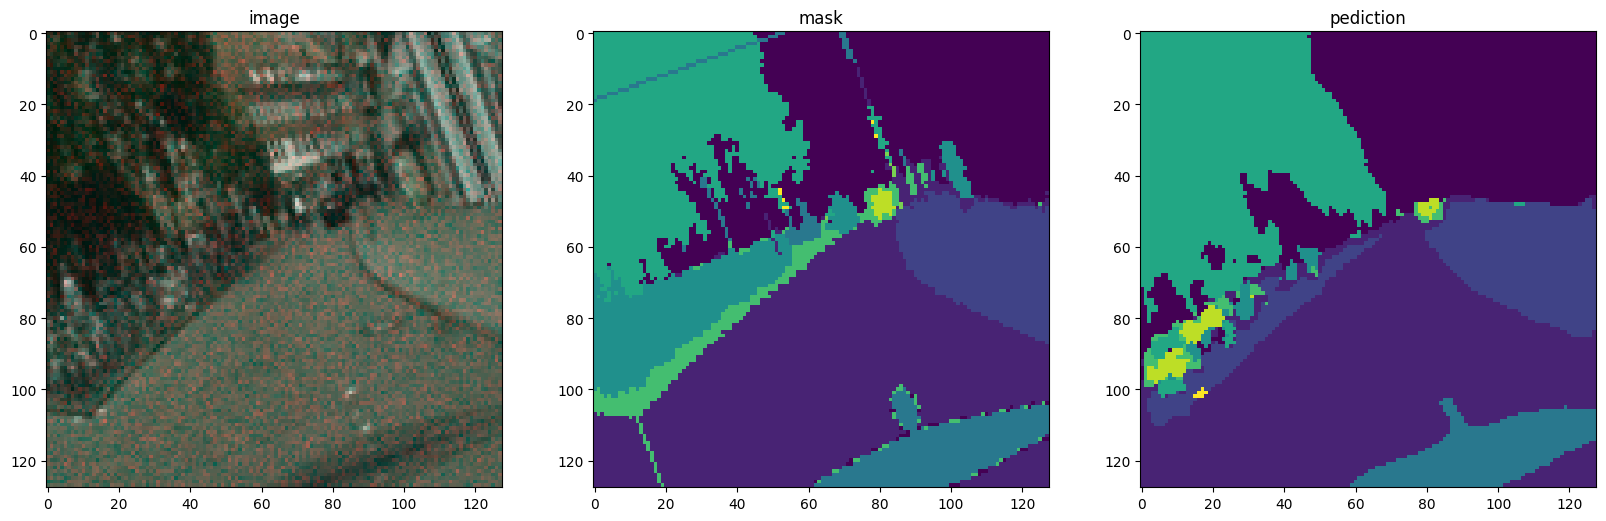

[Epochs-5/15]:
[Train_loss:0.7832 | Train_acc:0.3491 | Val_loss:0.7227 | Val_acc:0.3704]


 33%|███▎      | 5/15 [01:44<03:30, 21.00s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 6 epochs:


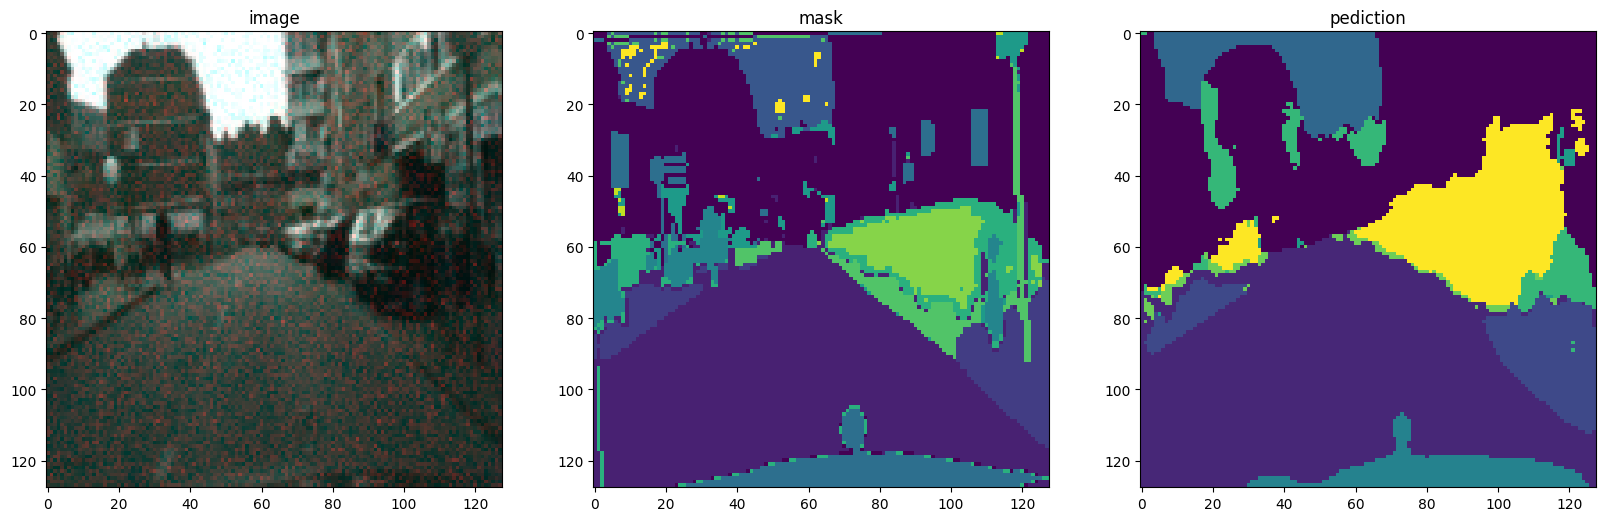

[Epochs-6/15]:
[Train_loss:0.7546 | Train_acc:0.3627 | Val_loss:0.7120 | Val_acc:0.3788]


 40%|████      | 6/15 [02:04<03:06, 20.70s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 7 epochs:


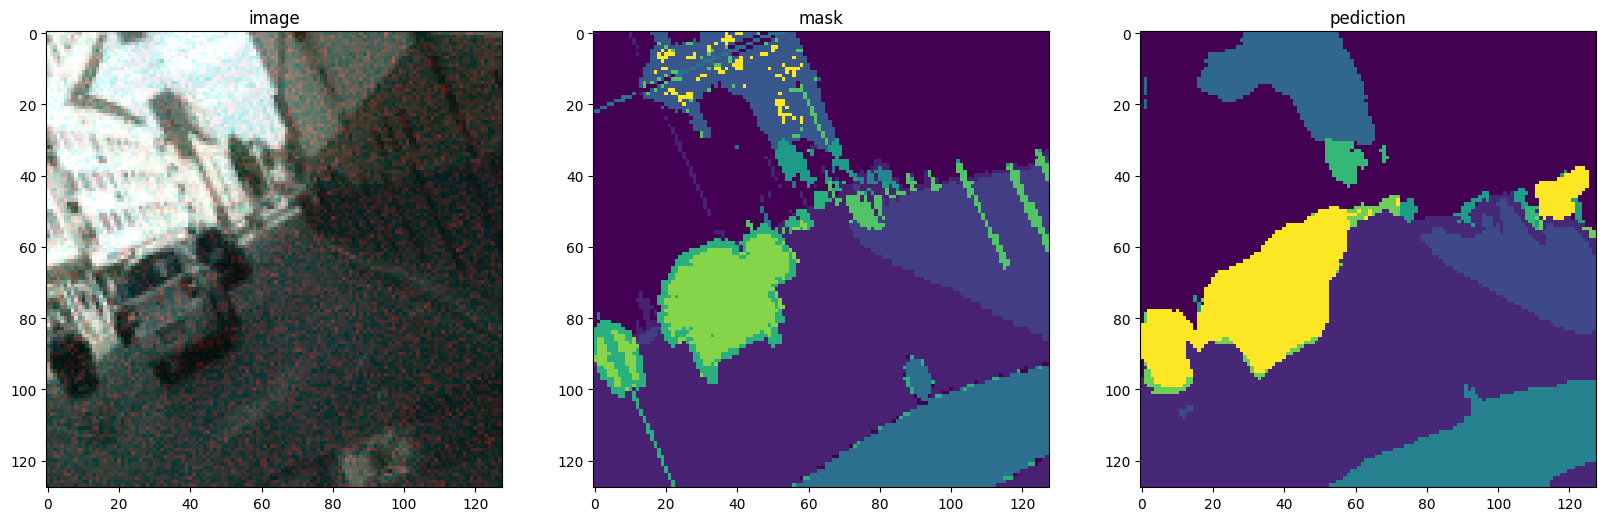

[Epochs-7/15]:
[Train_loss:0.7433 | Train_acc:0.3706 | Val_loss:0.6991 | Val_acc:0.3867]


 47%|████▋     | 7/15 [02:26<02:47, 21.00s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 8 epochs:


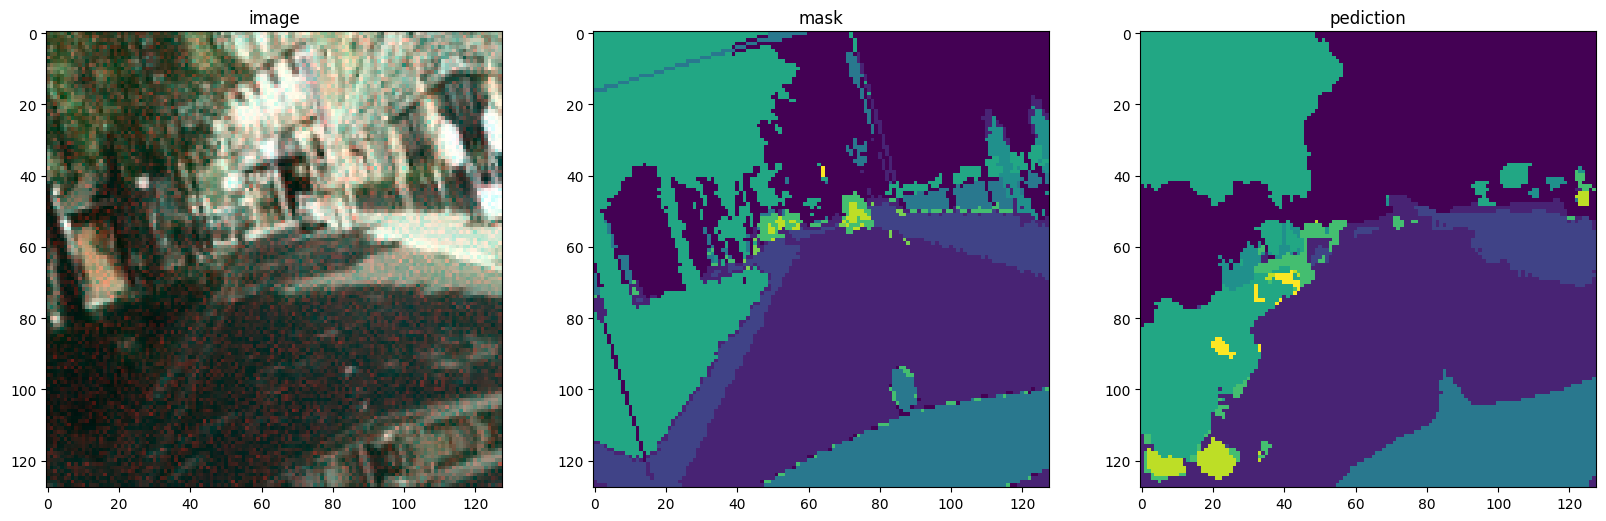

[Epochs-8/15]:
[Train_loss:0.7319 | Train_acc:0.3751 | Val_loss:0.6880 | Val_acc:0.3903]


 53%|█████▎    | 8/15 [02:46<02:25, 20.73s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 9 epochs:


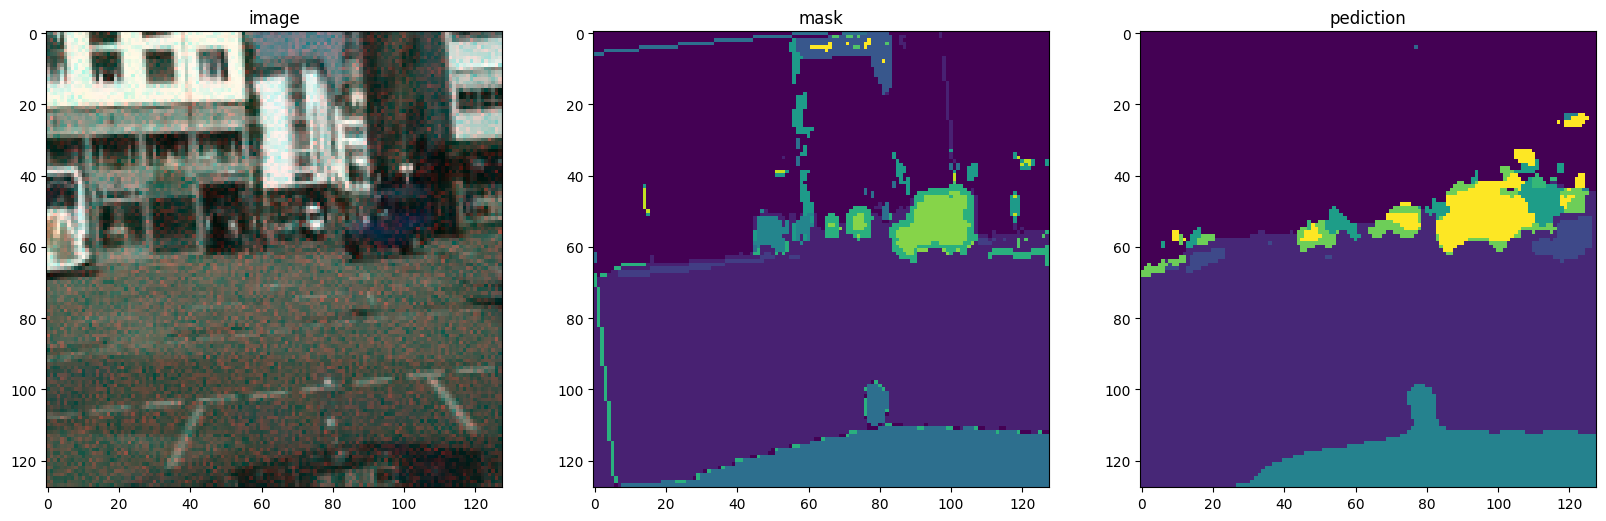

[Epochs-9/15]:
[Train_loss:0.7178 | Train_acc:0.3835 | Val_loss:0.6888 | Val_acc:0.3934]


 60%|██████    | 9/15 [03:07<02:05, 20.96s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 10 epochs:


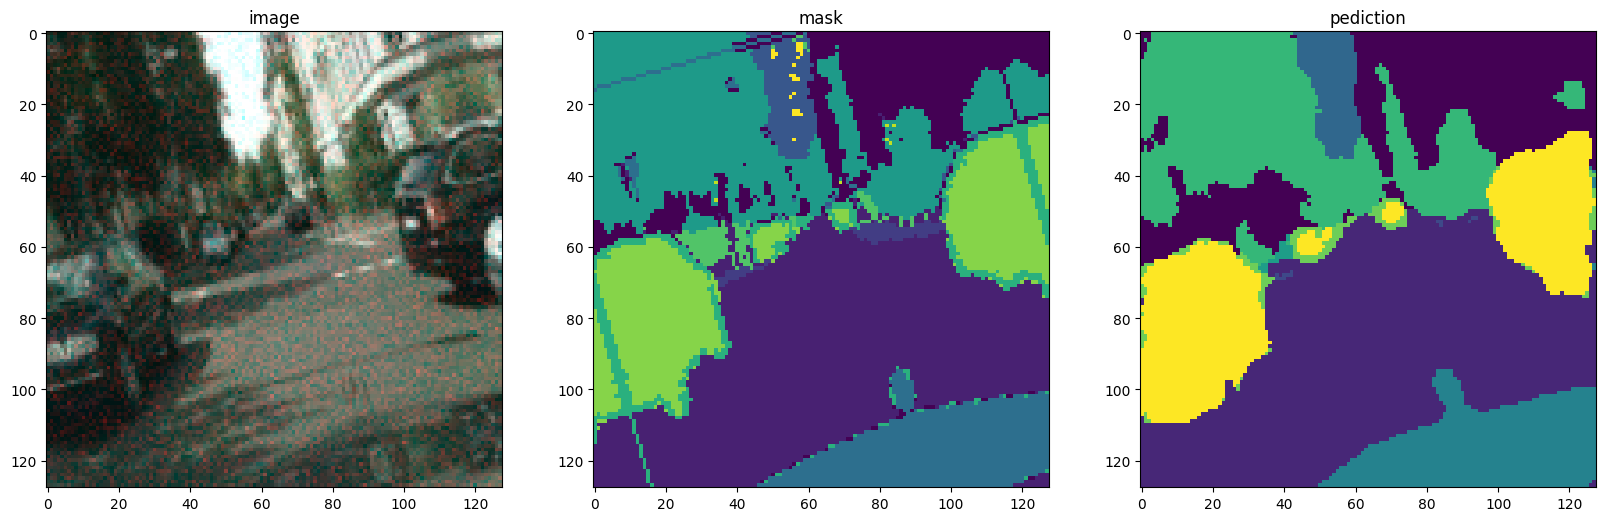

 67%|██████▋   | 10/15 [03:27<01:43, 20.64s/it]

[Epochs-10/15]:
[Train_loss:0.7175 | Train_acc:0.3824 | Val_loss:0.6826 | Val_acc:0.3914]


--------------------
Validation results after 11 epochs:


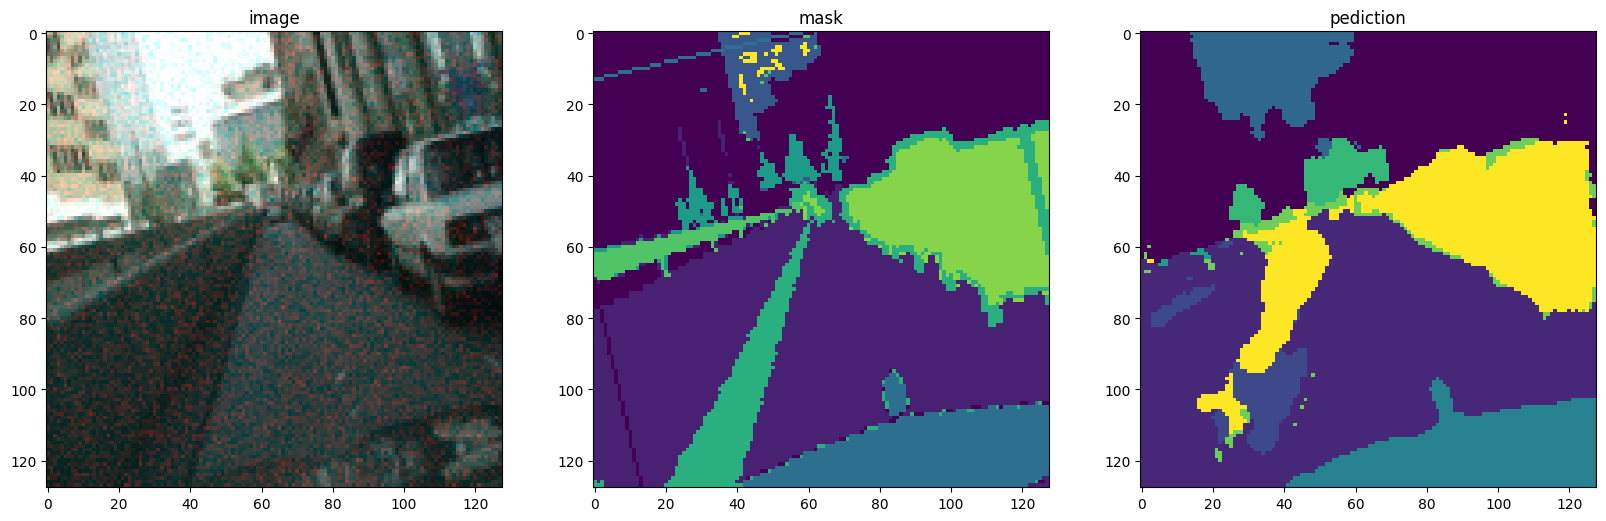

[Epochs-11/15]:
[Train_loss:0.7156 | Train_acc:0.3833 | Val_loss:0.6839 | Val_acc:0.3947]


 73%|███████▎  | 11/15 [03:49<01:23, 20.90s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 12 epochs:


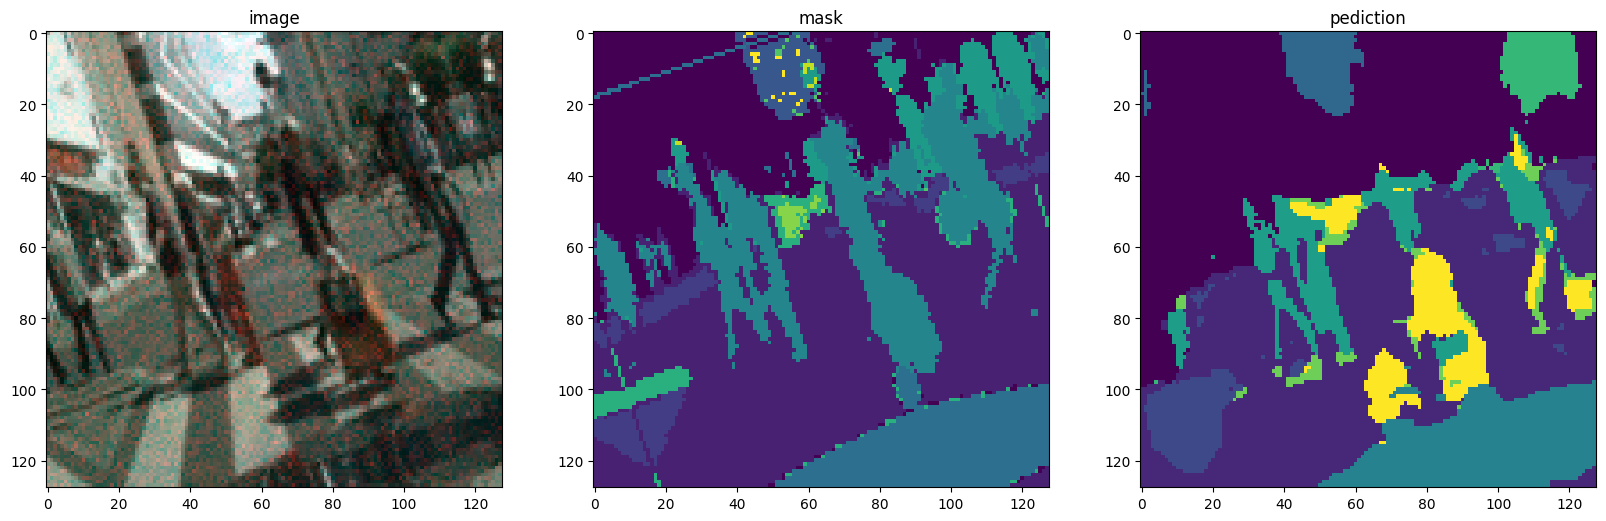

[Epochs-12/15]:
[Train_loss:0.7128 | Train_acc:0.3837 | Val_loss:0.6818 | Val_acc:0.3960]


 80%|████████  | 12/15 [04:09<01:01, 20.65s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------
Validation results after 13 epochs:


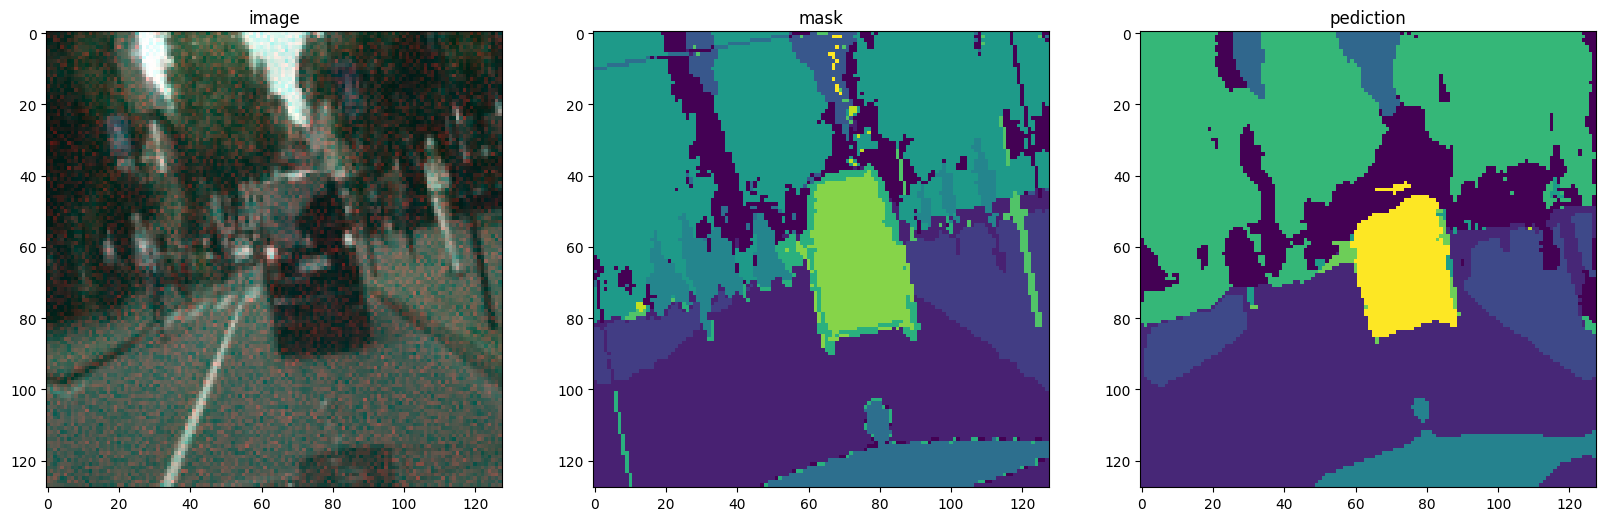

 87%|████████▋ | 13/15 [04:30<00:41, 20.86s/it]

[Epochs-13/15]:
[Train_loss:0.7175 | Train_acc:0.3793 | Val_loss:0.6803 | Val_acc:0.3955]


--------------------
Validation results after 14 epochs:


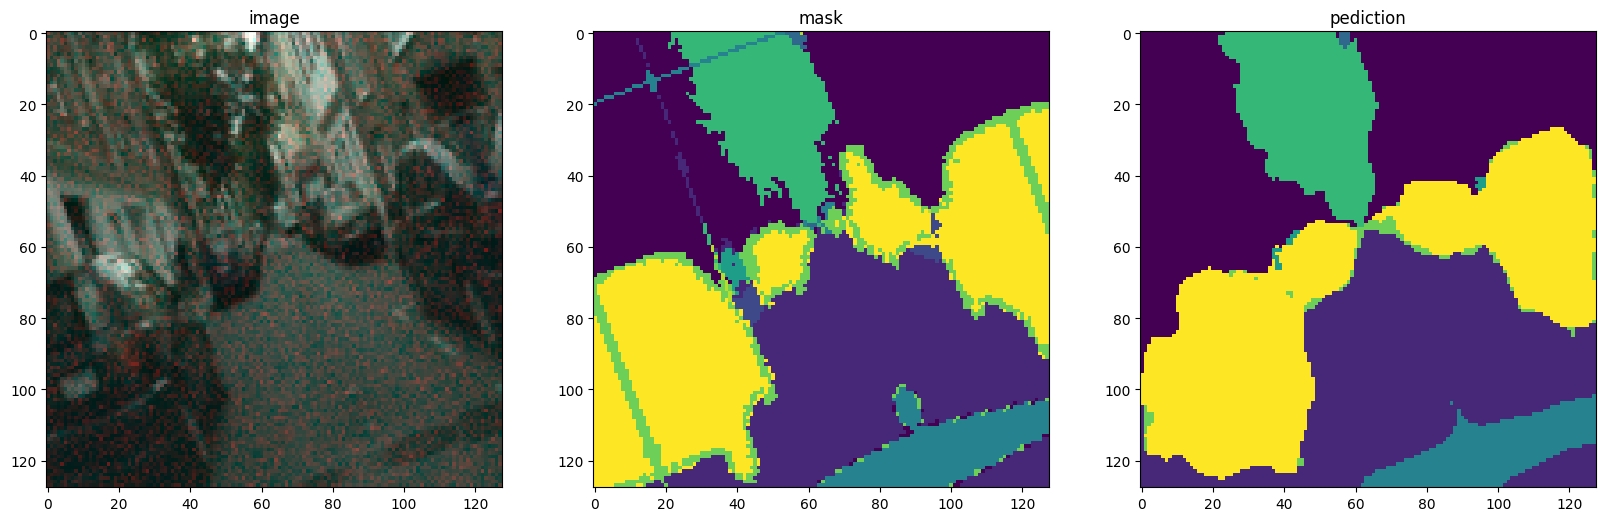

 93%|█████████▎| 14/15 [04:50<00:20, 20.59s/it]

[Epochs-14/15]:
[Train_loss:0.7150 | Train_acc:0.3828 | Val_loss:0.6832 | Val_acc:0.3949]


--------------------
Validation results after 15 epochs:


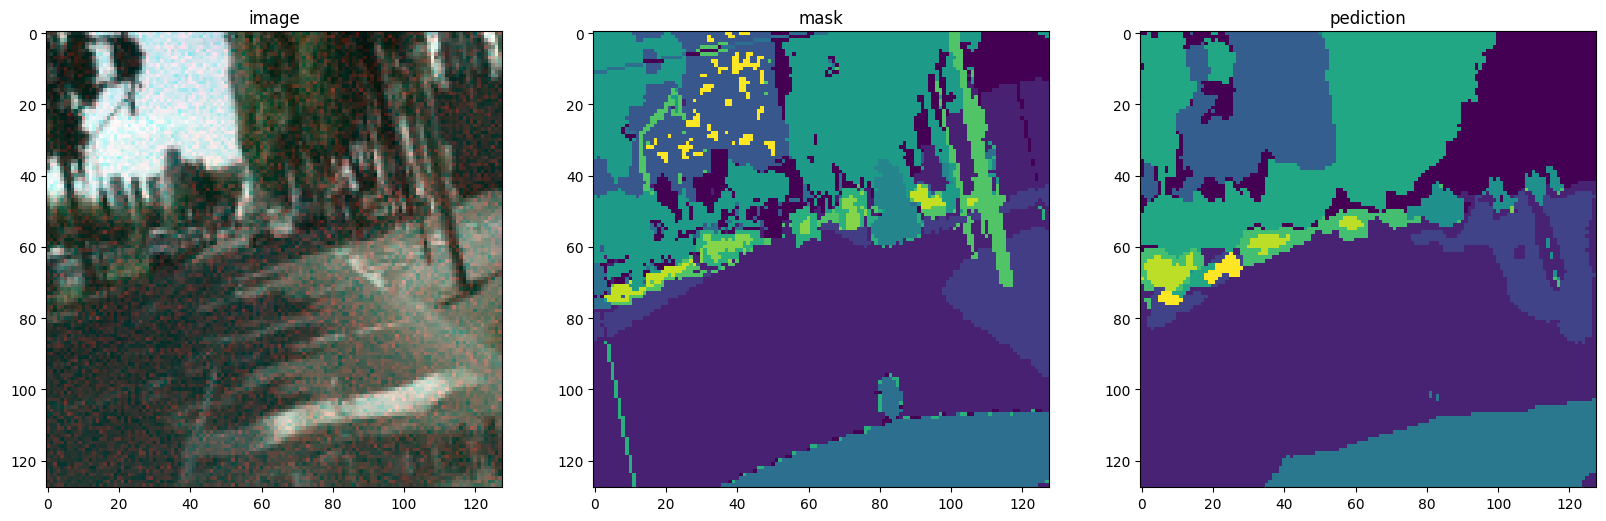

100%|██████████| 15/15 [05:12<00:00, 20.80s/it]

[Epochs-15/15]:
[Train_loss:0.7085 | Train_acc:0.3859 | Val_loss:0.6801 | Val_acc:0.3939]


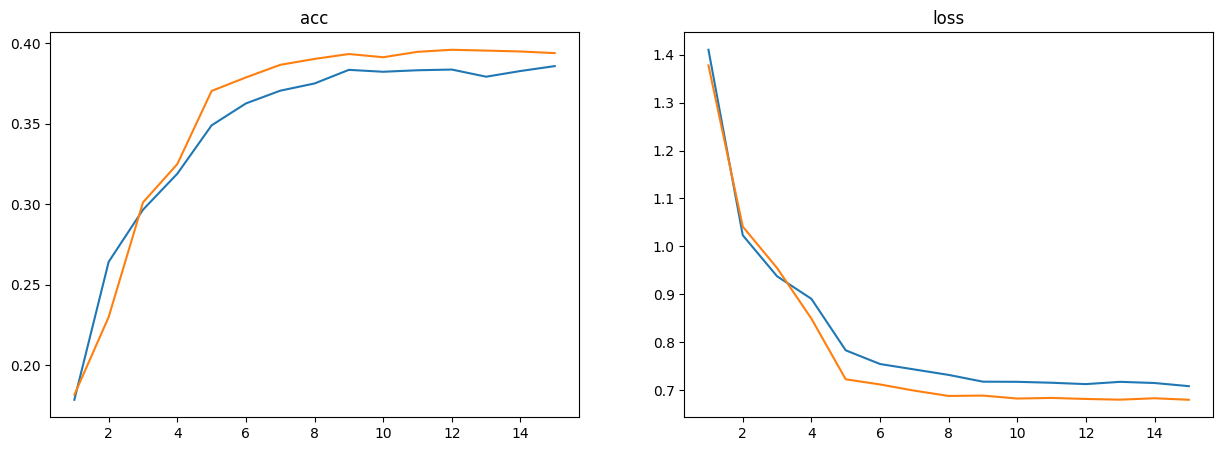

In [ ]:
trainer.train()

## Save model2

In [ ]:
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/b21ai056_mini_proj_3/Model_2.pth")

## Testing model2 on regular and modified dataset

In [ ]:
# Create an instance of your model2 class
model2 = Net(num_classes=OUTPUT_CLASSES)

# Load the model2 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_2.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model2
model2.load_state_dict(new_state_dict)

# Set the model2 to evaluation mode
model2.eval()

validator = Validator(model2, val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)


Validation Accuracy: 0.3848993134465663


In [ ]:
# new_val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)
validator = Validator(model2, new_val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.4050679343573656


## Creating modified dataset2 applying same modifications but using openCV (earlier done with Albumentation Library)

In [ ]:
OUTPUT_PATH = '/content/drive/MyDrive/b21ai056_mini_proj_3/train_dataset_new'

# Create the main output directory if it doesn't exist
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Create sub-folders for images and masks within the main output directory
OUTPUT_IMAGE_SUBFOLDER = os.path.join(OUTPUT_PATH, 'images')
OUTPUT_MASK_SUBFOLDER = os.path.join(OUTPUT_PATH, 'masks')

os.makedirs(OUTPUT_IMAGE_SUBFOLDER, exist_ok=True)
os.makedirs(OUTPUT_MASK_SUBFOLDER, exist_ok=True)

# Get the list of image and mask files
image_files = glob.glob(os.path.join(INPUT_PATH, 'train', '*.jpg'))
mask_files = glob.glob(os.path.join(INPUT_PATH_MASK, 'train', '*.jpg'))

# Define the maximum rotation angle (0-25 degrees)
max_rotation_angle = 25
print(len(image_files))
for i in range(len(image_files)):
    # Load the image and mask
    image = cv2.imread(image_files[i])
    mask = cv2.imread(mask_files[i])

    # Randomly generate a rotation angle between 0 and max_rotation_angle
    rotation_angle = uniform(0, max_rotation_angle)
    # Rotate both the image and mask by the same angle
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
    rotated_mask = cv2.warpAffine(mask, rot_matrix, (mask.shape[1], mask.shape[0]))

    # Apply random noise to the image
    noise = np.zeros(rotated_image.shape, np.uint8)
    cv2.randn(noise, 0, 25.5)
    # noise = np.random.normal(0, 1, rotated_image.shape).astype(np.uint8)
    noisy_image = cv2.add(rotated_image, noise)

    # Save the rotated and noisy image to the 'images' sub-folder
    image_name = os.path.basename(image_files[i])
    cv2.imwrite(os.path.join(OUTPUT_IMAGE_SUBFOLDER, image_name), noisy_image)

    # Save the rotated mask to the 'masks' sub-folder
    mask_name = os.path.basename(mask_files[i])
    cv2.imwrite(os.path.join(OUTPUT_MASK_SUBFOLDER, mask_name), rotated_mask)

print("Images and masks have been processed and saved.")


2975
Images and masks have been processed and saved.


In [ ]:
OUTPUT_PATH = '/content/drive/MyDrive/b21ai056_mini_proj_3/validation_dataset_new'

# Create the main output directory if it doesn't exist
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Create sub-folders for images and masks within the main output directory
OUTPUT_IMAGE_SUBFOLDER = os.path.join(OUTPUT_PATH, 'images')
OUTPUT_MASK_SUBFOLDER = os.path.join(OUTPUT_PATH, 'masks')

os.makedirs(OUTPUT_IMAGE_SUBFOLDER, exist_ok=True)
os.makedirs(OUTPUT_MASK_SUBFOLDER, exist_ok=True)

# Get the list of image and mask files
image_files = glob.glob(os.path.join(INPUT_PATH, 'val', '*.jpg'))
mask_files = glob.glob(os.path.join(INPUT_PATH_MASK, 'val', '*.jpg'))

# Define the maximum rotation angle (0-25 degrees)
max_rotation_angle = 25
print(len(image_files))
for i in range(len(image_files)):
    # Load the image and mask
    image = cv2.imread(image_files[i])
    mask = cv2.imread(mask_files[i])

    # Randomly generate a rotation angle between 0 and max_rotation_angle
    rotation_angle = uniform(0, max_rotation_angle)
    # Rotate both the image and mask by the same angle
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
    rotated_mask = cv2.warpAffine(mask, rot_matrix, (mask.shape[1], mask.shape[0]))

    # Apply random noise to the image
    noise = np.zeros(rotated_image.shape, np.uint8)
    cv2.randn(noise, 0, 25.5)
    # noise = np.random.normal(0, 1, rotated_image.shape).astype(np.uint8)
    noisy_image = cv2.add(rotated_image, noise)

    # Save the rotated and noisy image to the 'images' sub-folder
    image_name = os.path.basename(image_files[i])
    cv2.imwrite(os.path.join(OUTPUT_IMAGE_SUBFOLDER, image_name), noisy_image)

    # Save the rotated mask to the 'masks' sub-folder
    mask_name = os.path.basename(mask_files[i])
    cv2.imwrite(os.path.join(OUTPUT_MASK_SUBFOLDER, mask_name), rotated_mask)

print("Images and masks have been processed and saved.")


500
Images and masks have been processed and saved.


In [ ]:
folder = '/content/drive/MyDrive/b21ai056_mini_proj_3/train_dataset_new'
INPUT_PATH_1 = '/content/train_Dataset_new'

shutil.copytree(folder, INPUT_PATH_1)


'/content/train_Dataset_new'

In [ ]:
train_files1 = glob.glob(os.path.join(INPUT_PATH_1 + '/images', '*jpg'))
train_files_mask1 = glob.glob(os.path.join(INPUT_PATH_1 + '/masks', '*jpg'))

print('Total train images:', len(train_files1))
print('Total train mask:', len(train_files_mask1))


Total train images: 2975
Total train mask: 2975


In [ ]:
folder = '/content/drive/MyDrive/b21ai056_mini_proj_3/validation_dataset_new'
INPUT_PATH_2 = '/content/Validation_Dataset_new'

shutil.copytree(folder, INPUT_PATH_2)


'/content/Validation_Dataset_new'

In [ ]:
test_files1 = glob.glob(os.path.join(INPUT_PATH_2 + '/images', '*jpg'))
test_files_mask1 = glob.glob(os.path.join(INPUT_PATH_2 + '/masks', '*jpg'))

print('Total test images:', len(test_files1))
print('Total test mask:', len(test_files_mask1))


Total test images: 500
Total test mask: 500


In [ ]:
train_data_obj1 = Dataset(train_files1, train_files_mask1, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [ ]:
val_data_obj1 = Dataset(test_files1, test_files_mask1, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

## Data Visualisation

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(9, dtype=torch.int32) tensor(0, dtype=torch.int32)


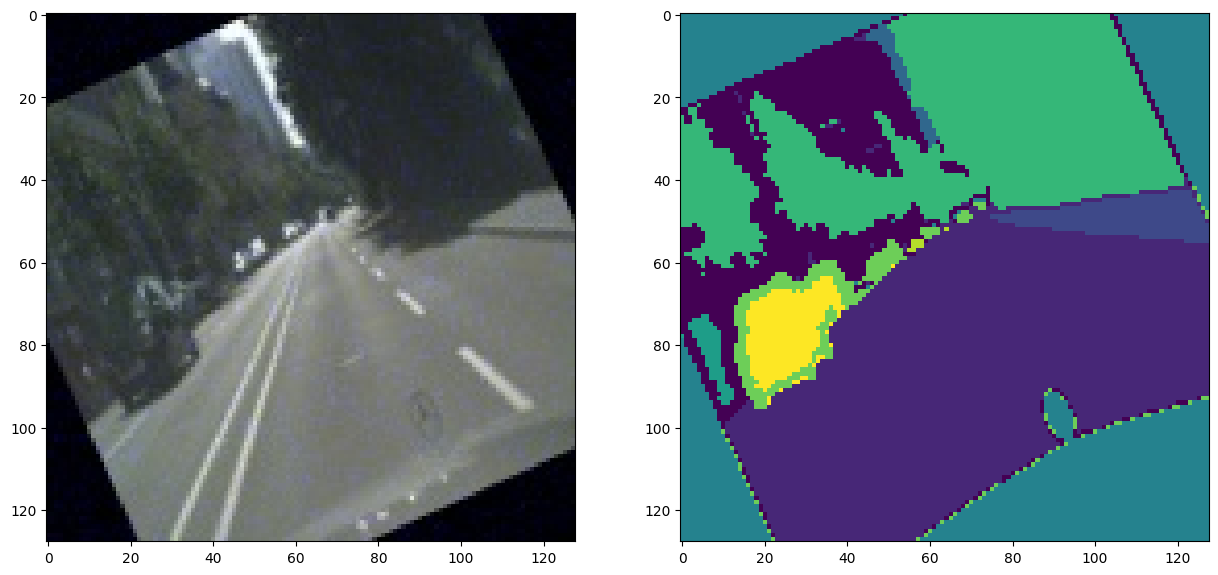

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9529) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


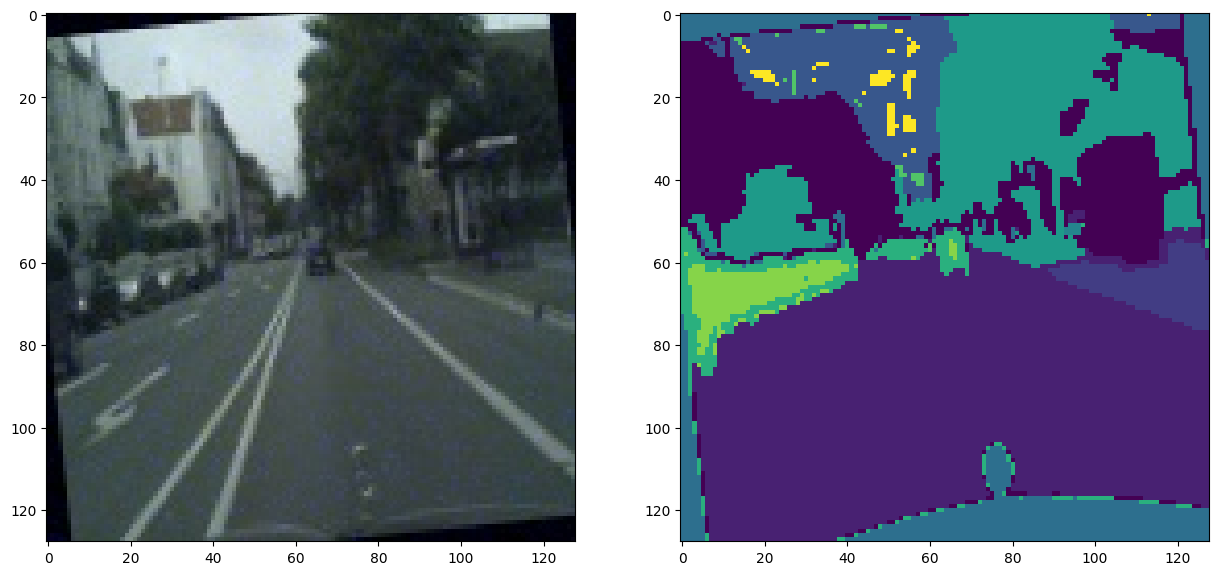

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


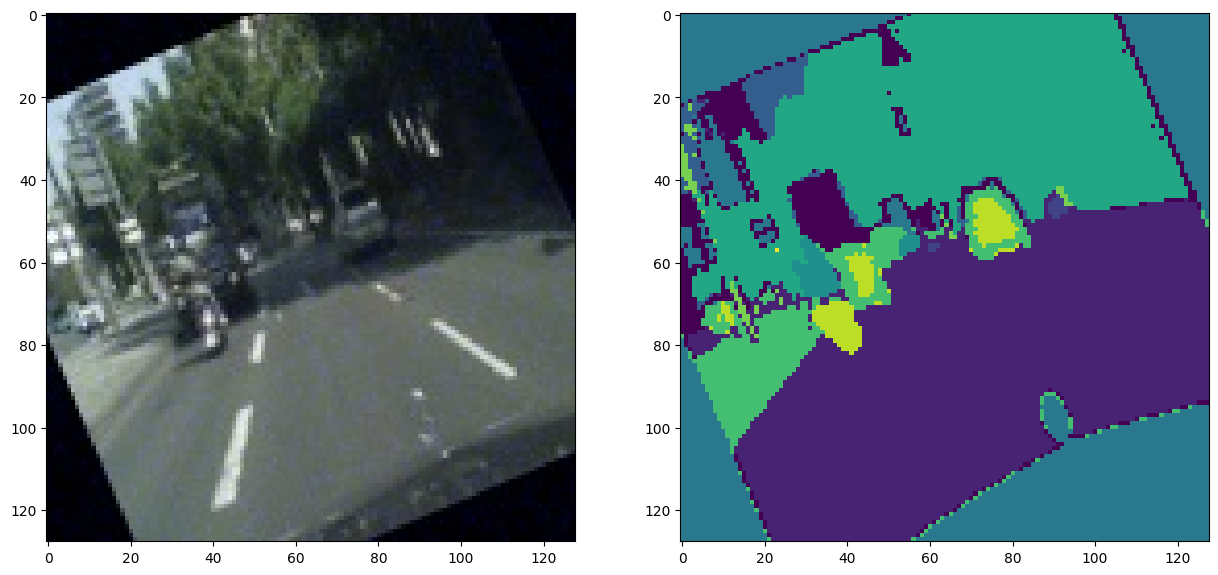

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9412) tensor(0.)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


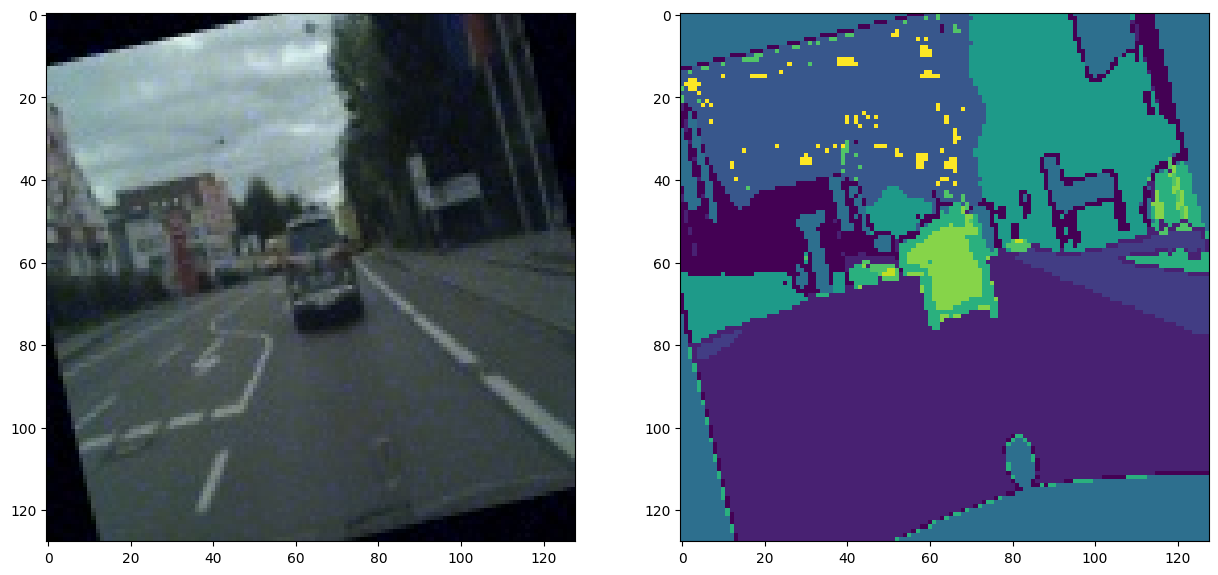

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


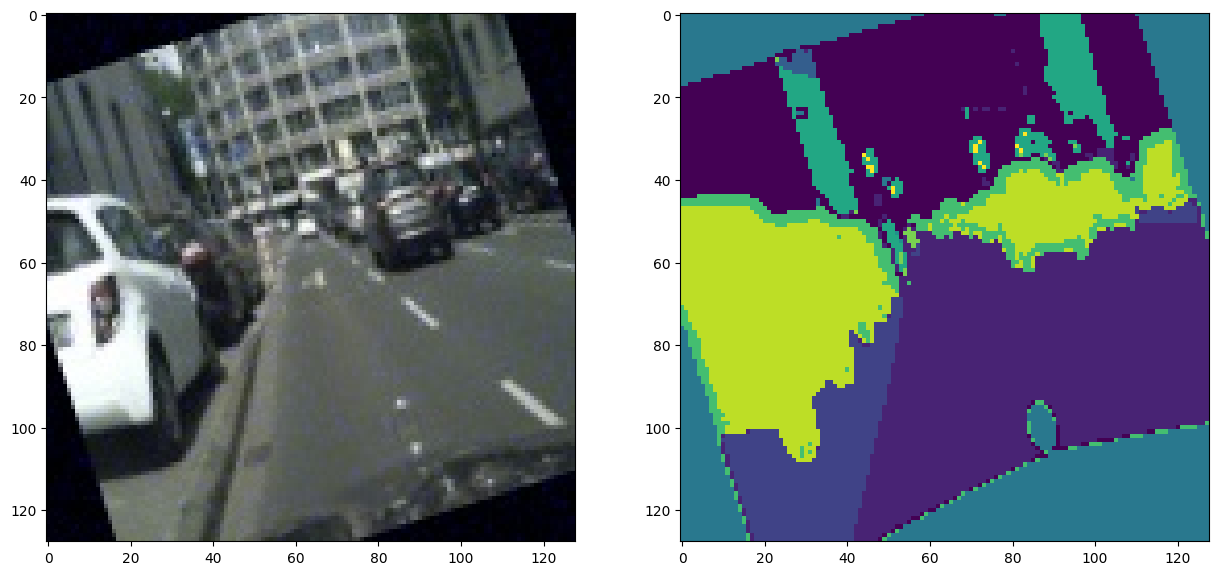

In [ ]:
for i in range(5):

    img,  msk = val_data_obj1.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

## Testing Model1 and Model2 on modified dataset2

In [ ]:
validator = Validator(model1, val_data_obj1, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.2530626944775066


In [ ]:
validator = Validator(model2, val_data_obj1, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.2212276727360455


-------------------------------Second Modified Model trained on modified dataset2---------------------------------------------

## Define models

In [ ]:
unet = Net(num_classes=OUTPUT_CLASSES)

## No of trainable parameters

In [ ]:
print(sum(p.numel() for p in unet.parameters()))

18010252


## Define loss function

In [ ]:
model = unet
loss_function = nn.CrossEntropyLoss()

## Define trainer object

In [ ]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_obj1,
                  val_data = val_data_obj1,
                  opti_name = 'SGD',
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE//2,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  step_size = SCHEDULER_STEP_SIZE,
                  path_to_save = "/content/drive/MyDrive/b21ai056_mini_proj_3/Final_model2"
                 )

## Start training

  0%|          | 0/15 [00:00<?, ?it/s]

--------------------
Validation results after 1 epochs:


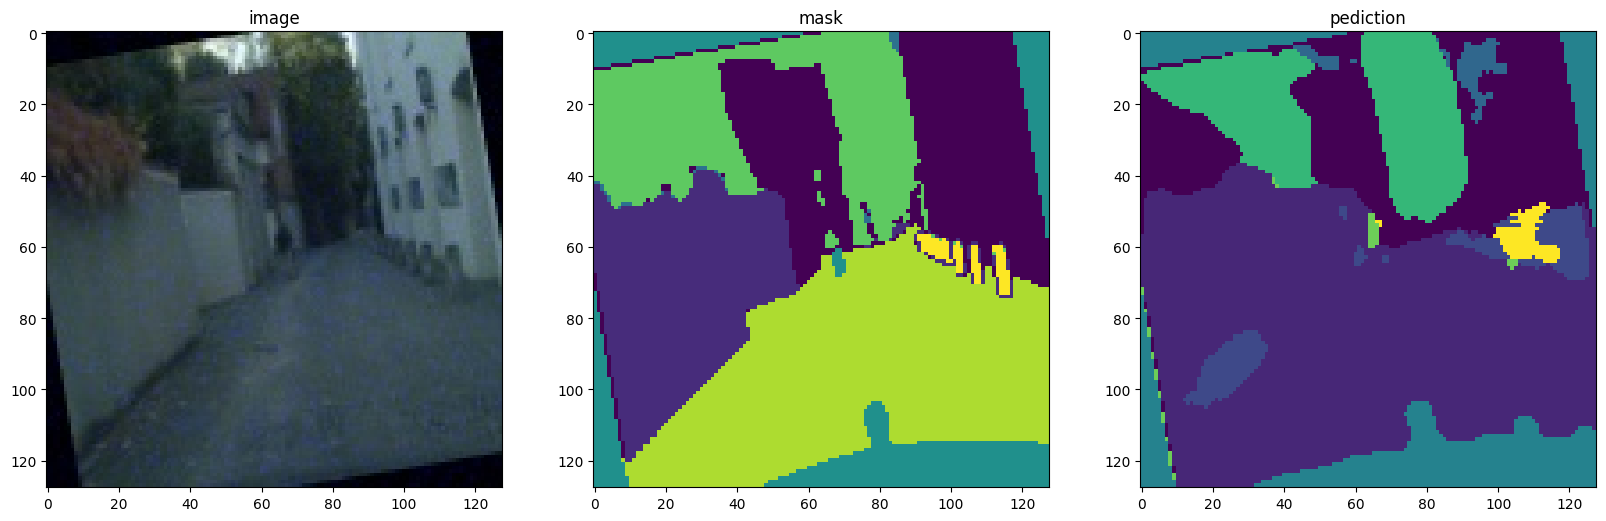

[Epochs-1/15]:
[Train_loss:0.8485 | Train_acc:0.3408 | Val_loss:0.7923 | Val_acc:0.3376]


  7%|▋         | 1/15 [01:20<18:41, 80.14s/it]

--------------------
Validation results after 2 epochs:


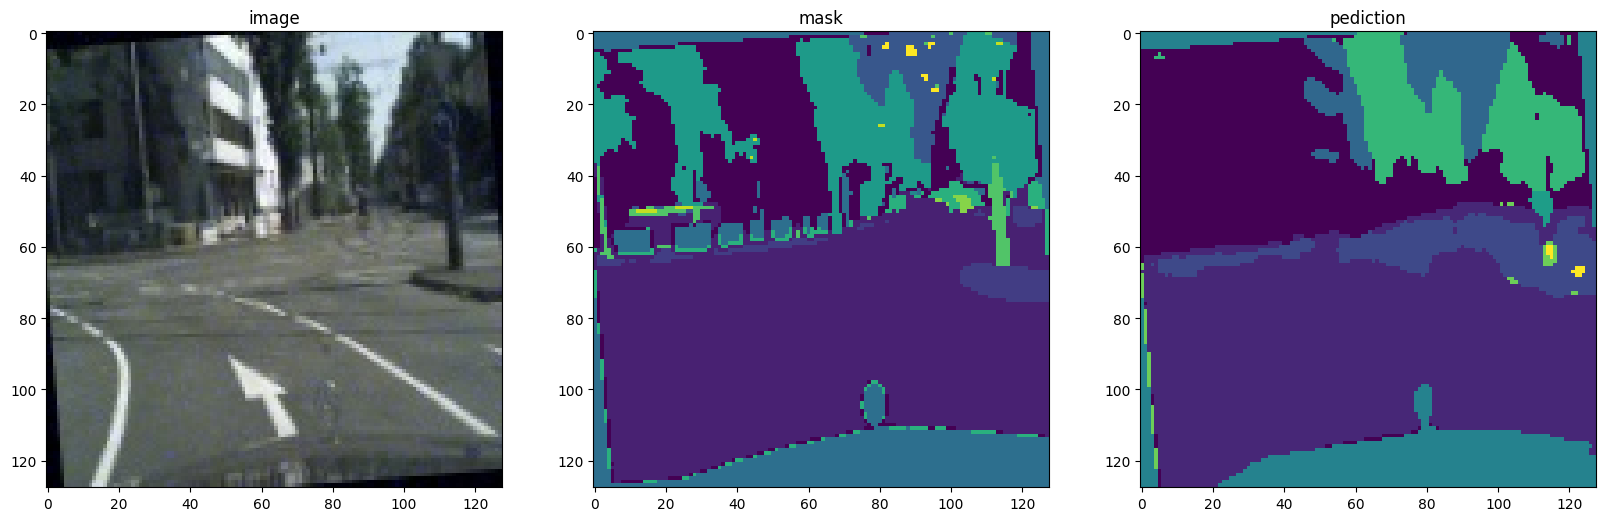

[Epochs-2/15]:
[Train_loss:0.6621 | Train_acc:0.4131 | Val_loss:0.6424 | Val_acc:0.4171]


 13%|█▎        | 2/15 [02:40<17:26, 80.53s/it]

--------------------
Validation results after 3 epochs:


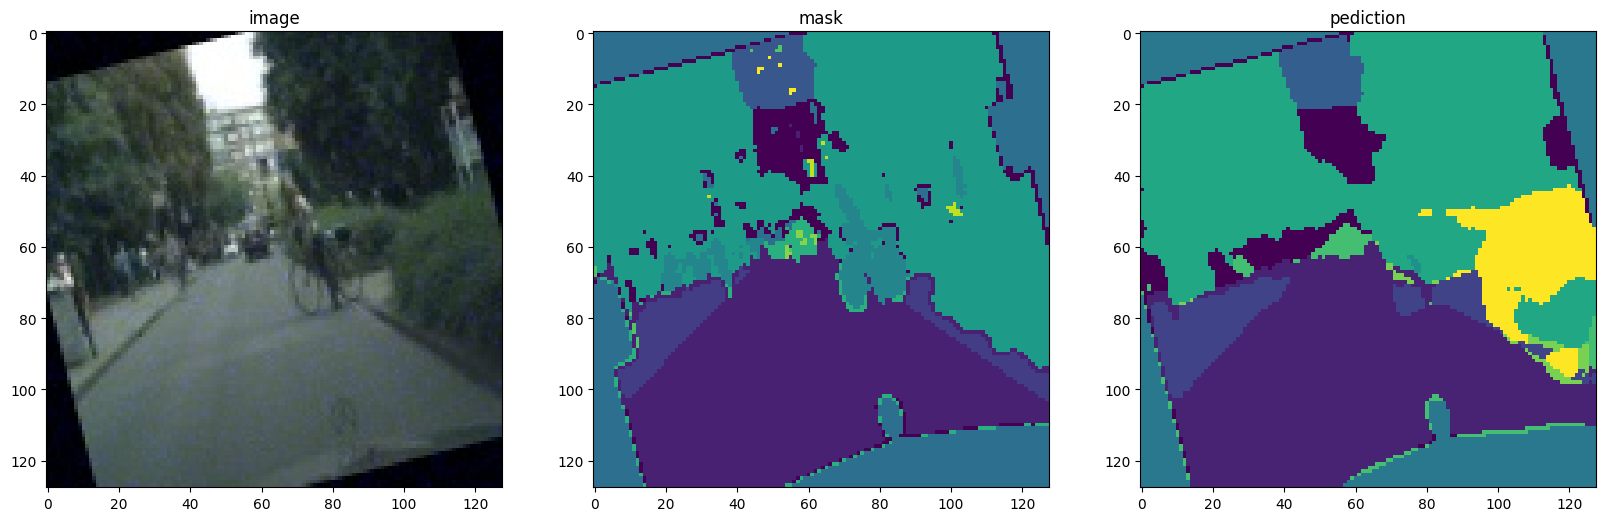

[Epochs-3/15]:
[Train_loss:0.5999 | Train_acc:0.4454 | Val_loss:0.6254 | Val_acc:0.4384]


 20%|██        | 3/15 [04:01<16:07, 80.61s/it]

--------------------
Validation results after 4 epochs:


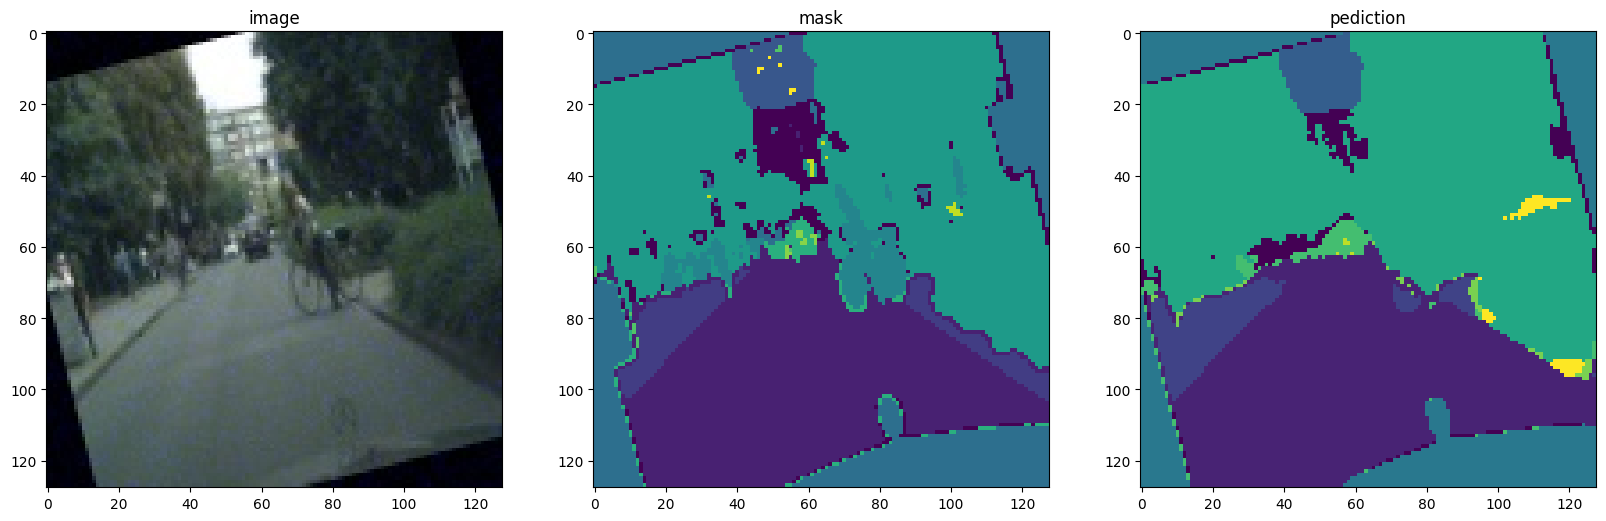

 27%|██▋       | 4/15 [05:23<14:50, 80.93s/it]

[Epochs-4/15]:
[Train_loss:0.5630 | Train_acc:0.4623 | Val_loss:0.6256 | Val_acc:0.4255]
--------------------
Validation results after 5 epochs:


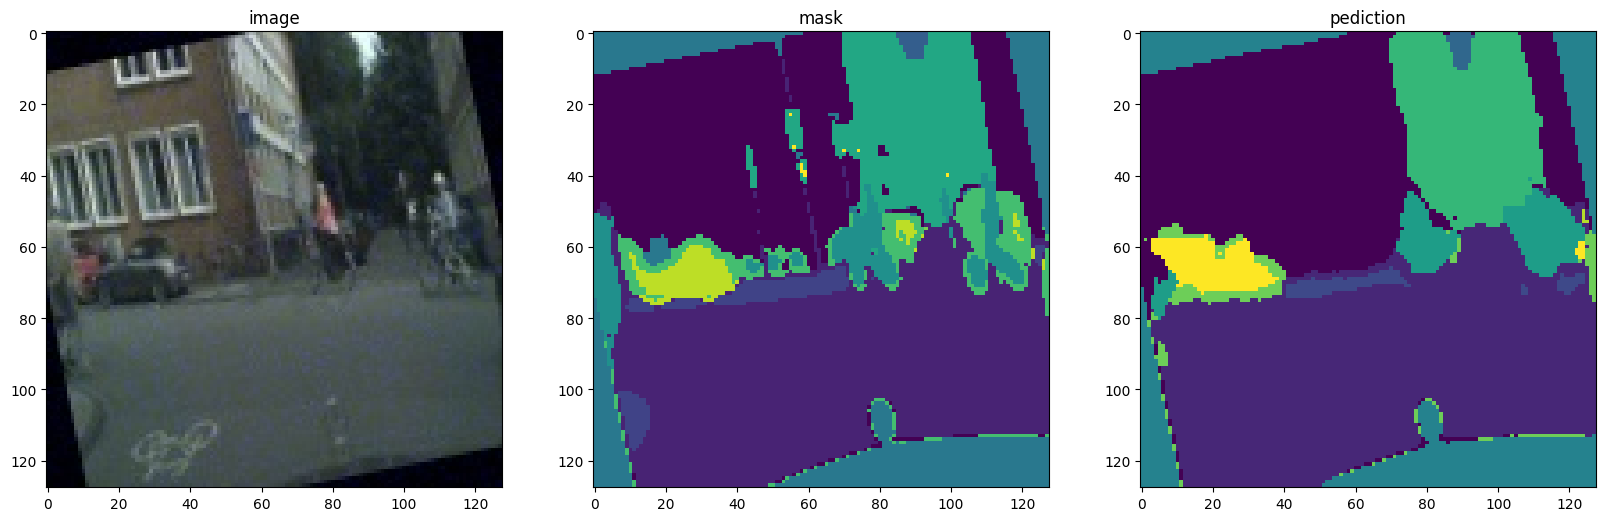

[Epochs-5/15]:
[Train_loss:0.4929 | Train_acc:0.4950 | Val_loss:0.5253 | Val_acc:0.4698]


 33%|███▎      | 5/15 [06:45<13:33, 81.33s/it]

--------------------
Validation results after 6 epochs:


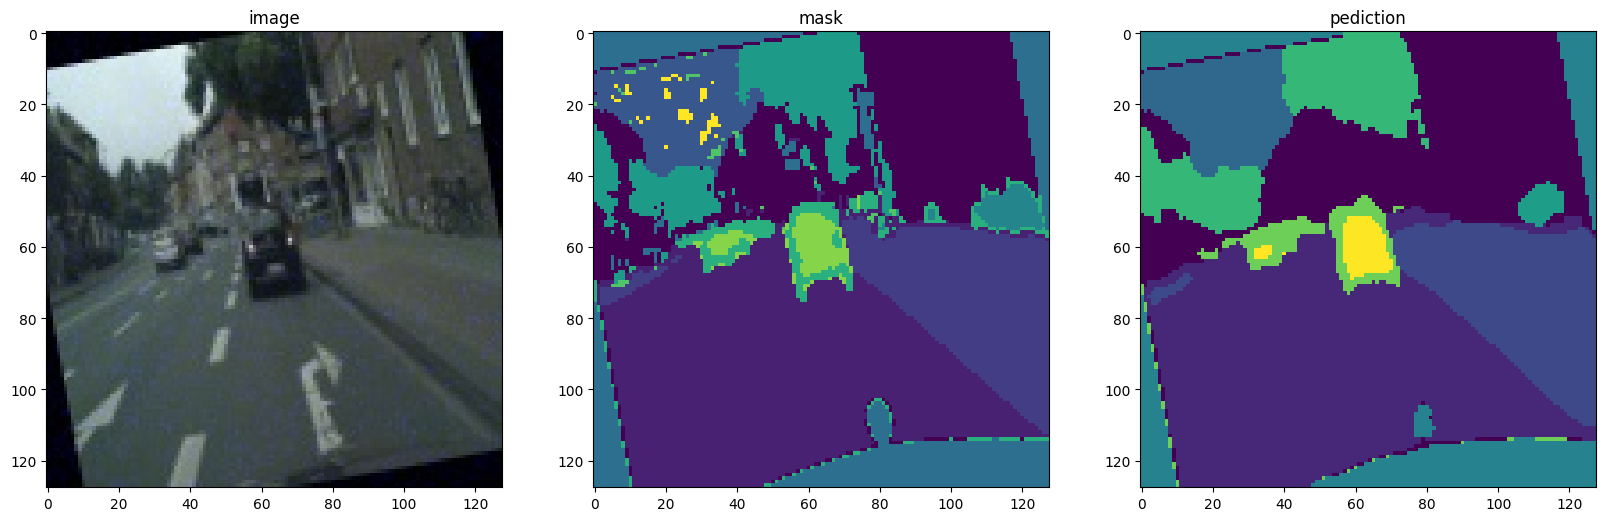

[Epochs-6/15]:
[Train_loss:0.4754 | Train_acc:0.5055 | Val_loss:0.5223 | Val_acc:0.4727]


 40%|████      | 6/15 [08:07<12:14, 81.57s/it]

--------------------
Validation results after 7 epochs:


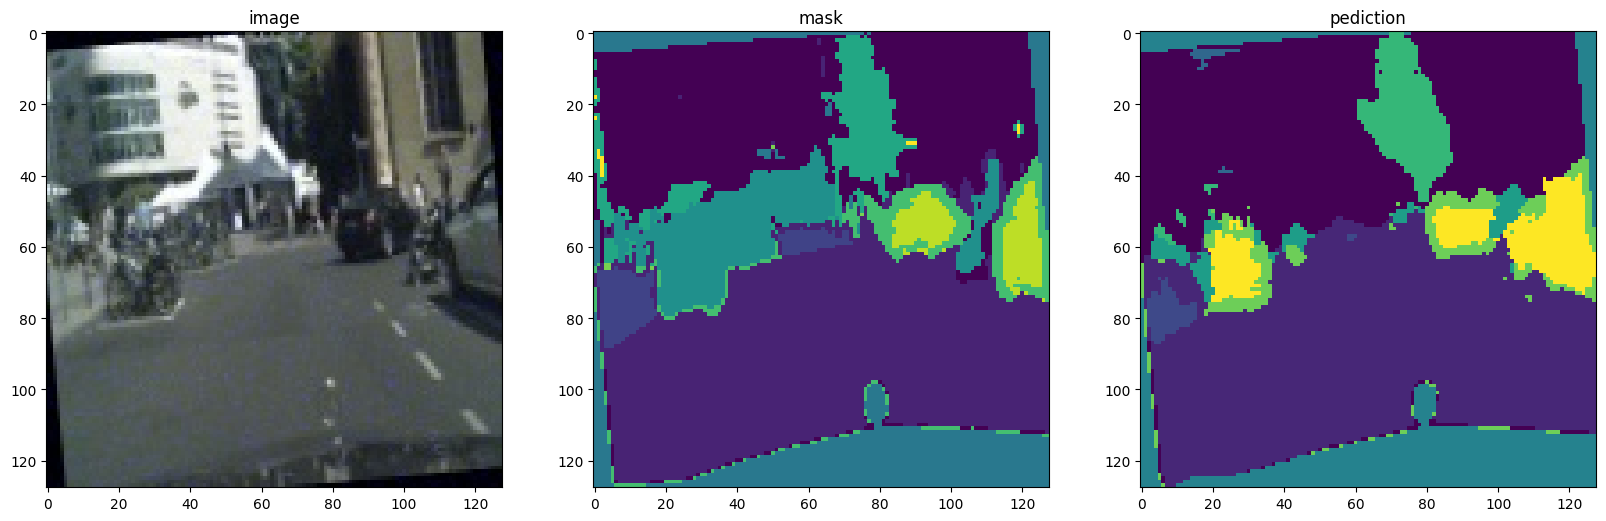

 47%|████▋     | 7/15 [09:28<10:51, 81.48s/it]

[Epochs-7/15]:
[Train_loss:0.4652 | Train_acc:0.5103 | Val_loss:0.5205 | Val_acc:0.4717]
--------------------
Validation results after 8 epochs:


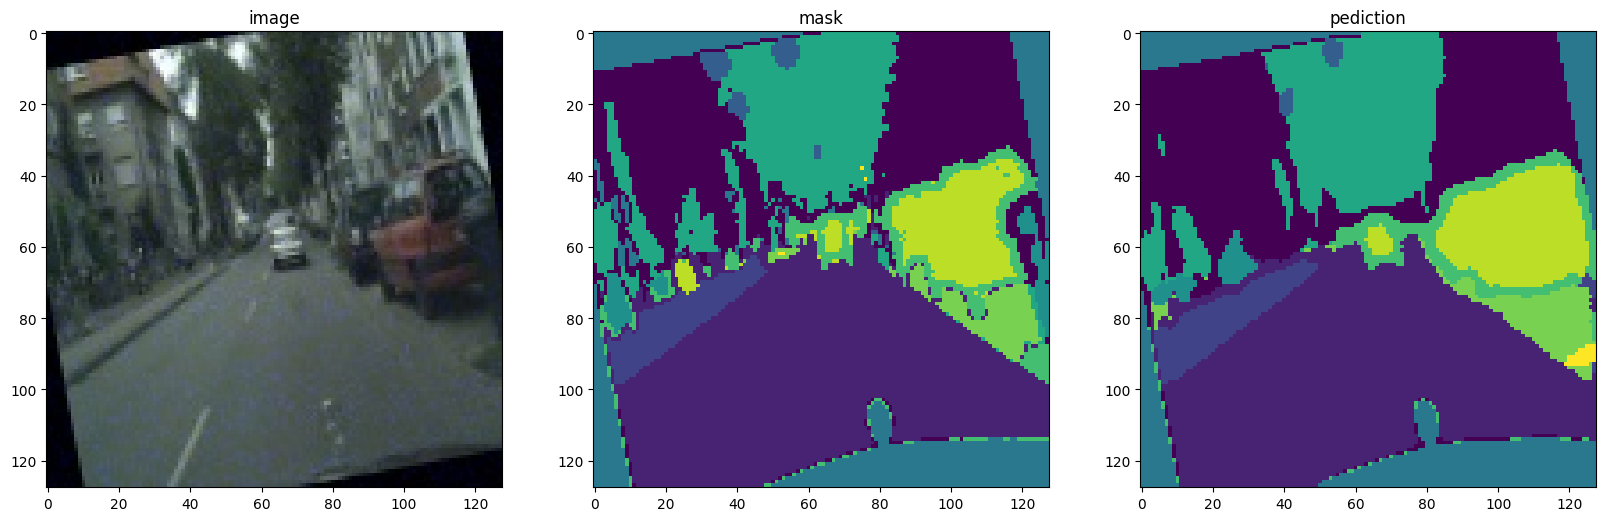

[Epochs-8/15]:
[Train_loss:0.4547 | Train_acc:0.5155 | Val_loss:0.5192 | Val_acc:0.4754]


 53%|█████▎    | 8/15 [10:48<09:27, 81.07s/it]

--------------------
Validation results after 9 epochs:


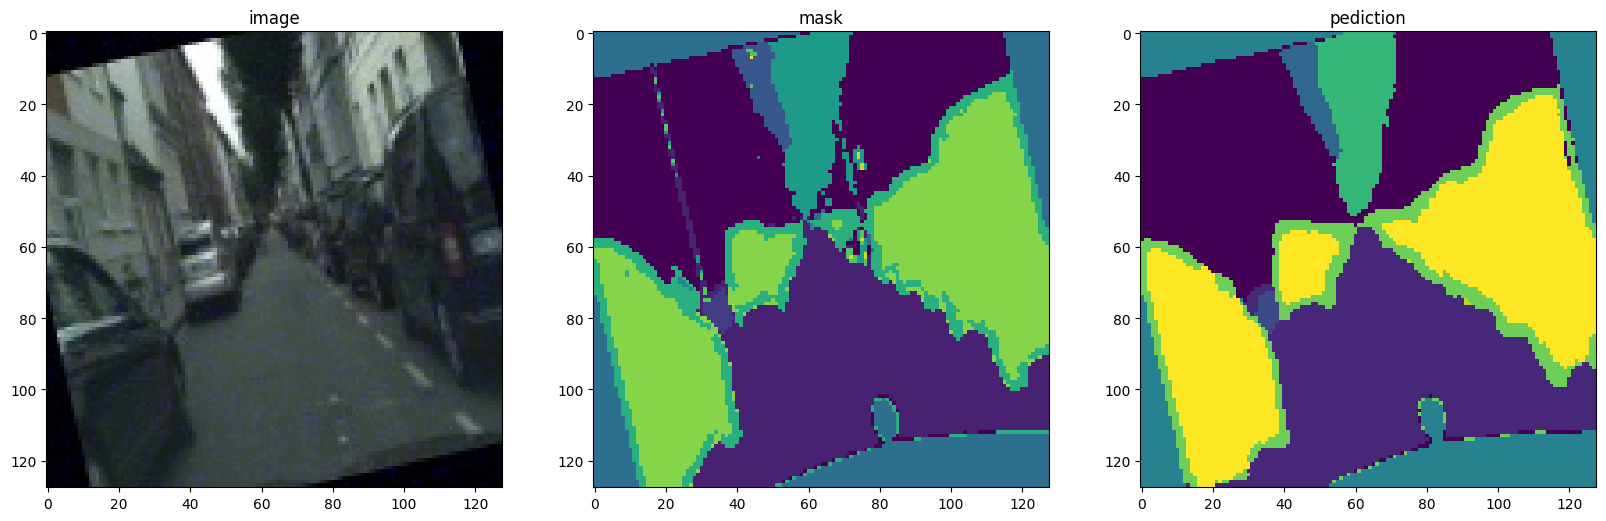

[Epochs-9/15]:
[Train_loss:0.4405 | Train_acc:0.5215 | Val_loss:0.5166 | Val_acc:0.4763]


 60%|██████    | 9/15 [12:09<08:05, 80.87s/it]

--------------------
Validation results after 10 epochs:


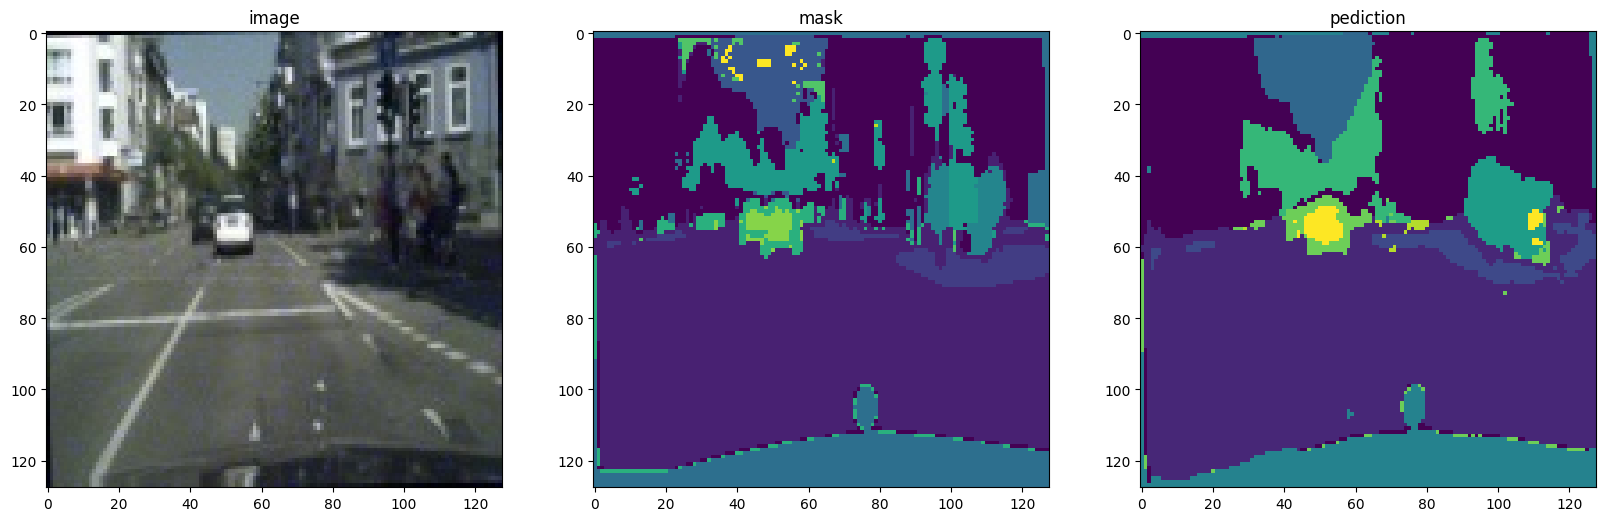

 67%|██████▋   | 10/15 [13:30<06:45, 81.04s/it]

[Epochs-10/15]:
[Train_loss:0.4388 | Train_acc:0.5245 | Val_loss:0.5158 | Val_acc:0.4744]
--------------------
Validation results after 11 epochs:


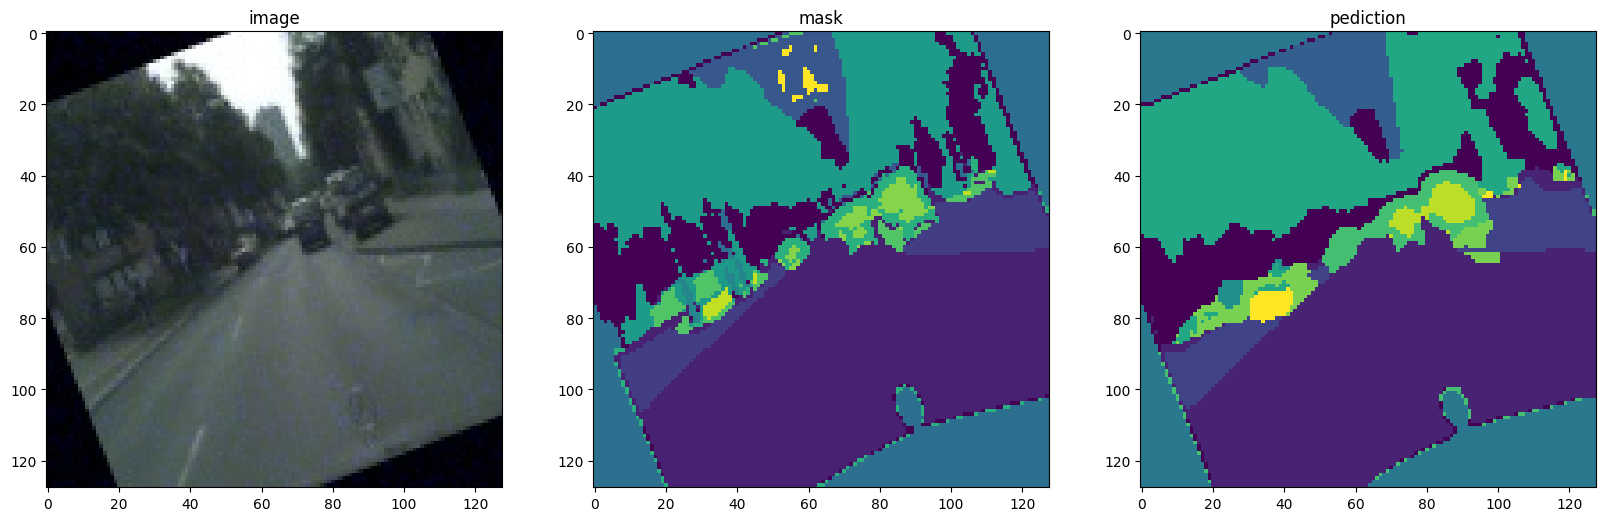

[Epochs-11/15]:
[Train_loss:0.4353 | Train_acc:0.5248 | Val_loss:0.5177 | Val_acc:0.4778]


 73%|███████▎  | 11/15 [14:51<05:24, 81.14s/it]

--------------------
Validation results after 12 epochs:


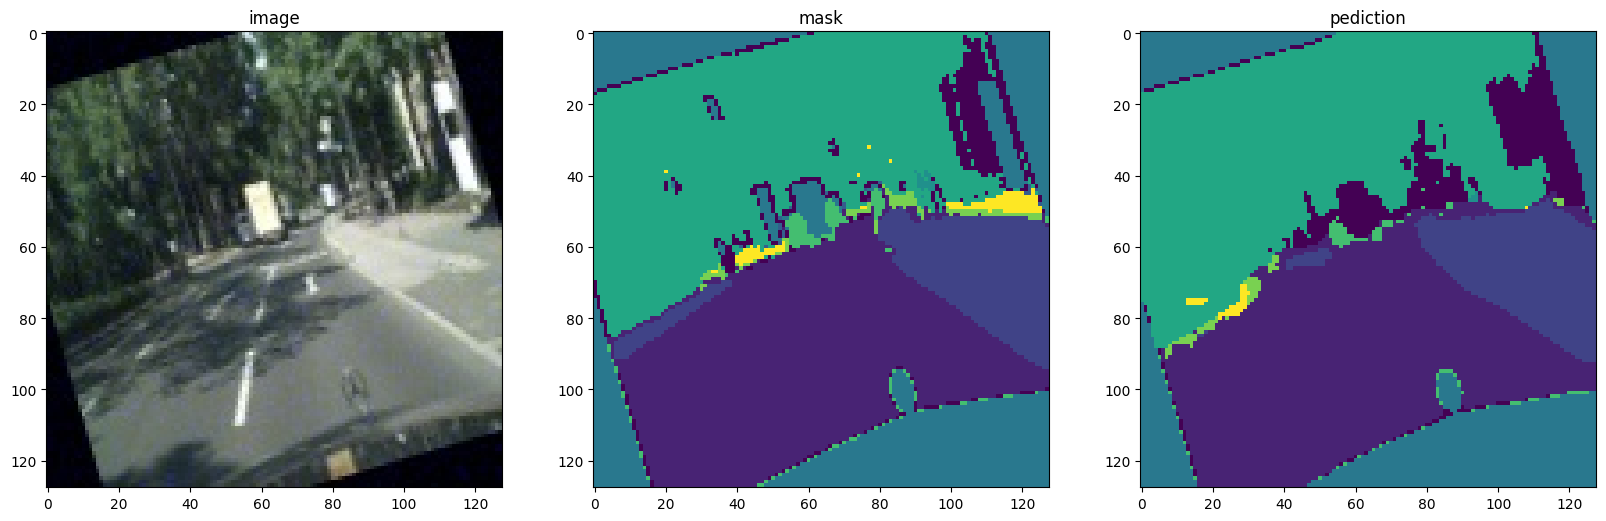

 80%|████████  | 12/15 [16:11<04:02, 80.77s/it]

[Epochs-12/15]:
[Train_loss:0.4343 | Train_acc:0.5249 | Val_loss:0.5146 | Val_acc:0.4759]
--------------------
Validation results after 13 epochs:


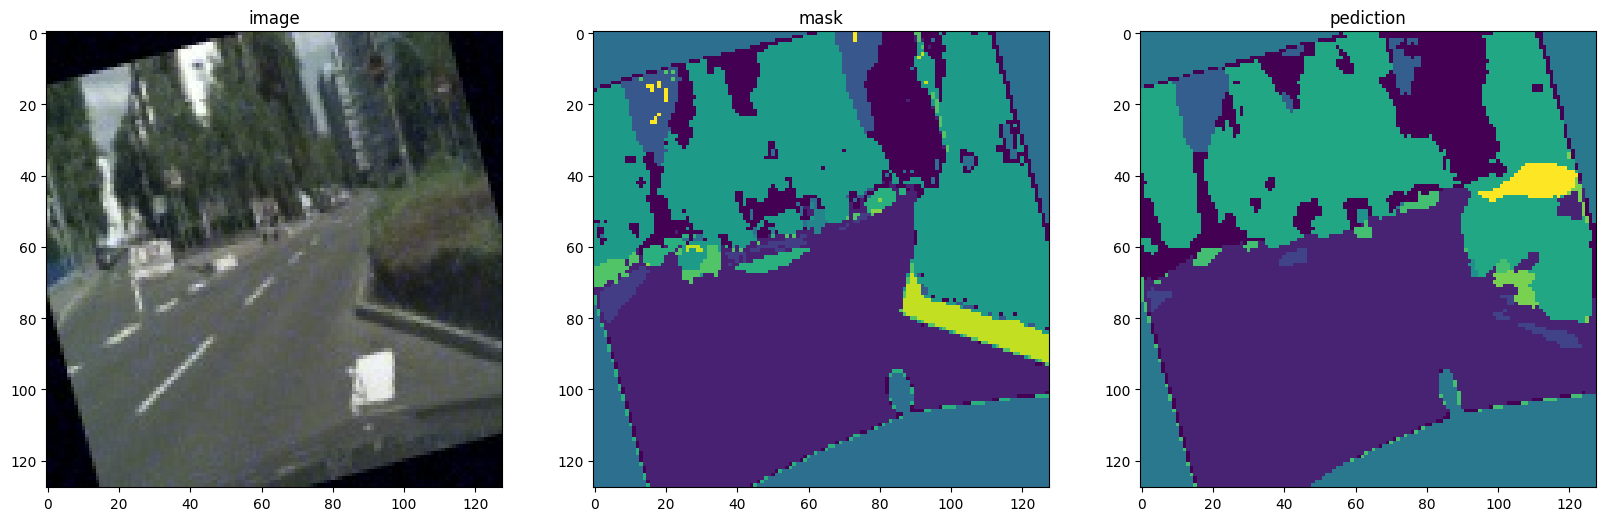

 87%|████████▋ | 13/15 [17:32<02:41, 80.88s/it]

[Epochs-13/15]:
[Train_loss:0.4325 | Train_acc:0.5246 | Val_loss:0.5162 | Val_acc:0.4745]
--------------------
Validation results after 14 epochs:


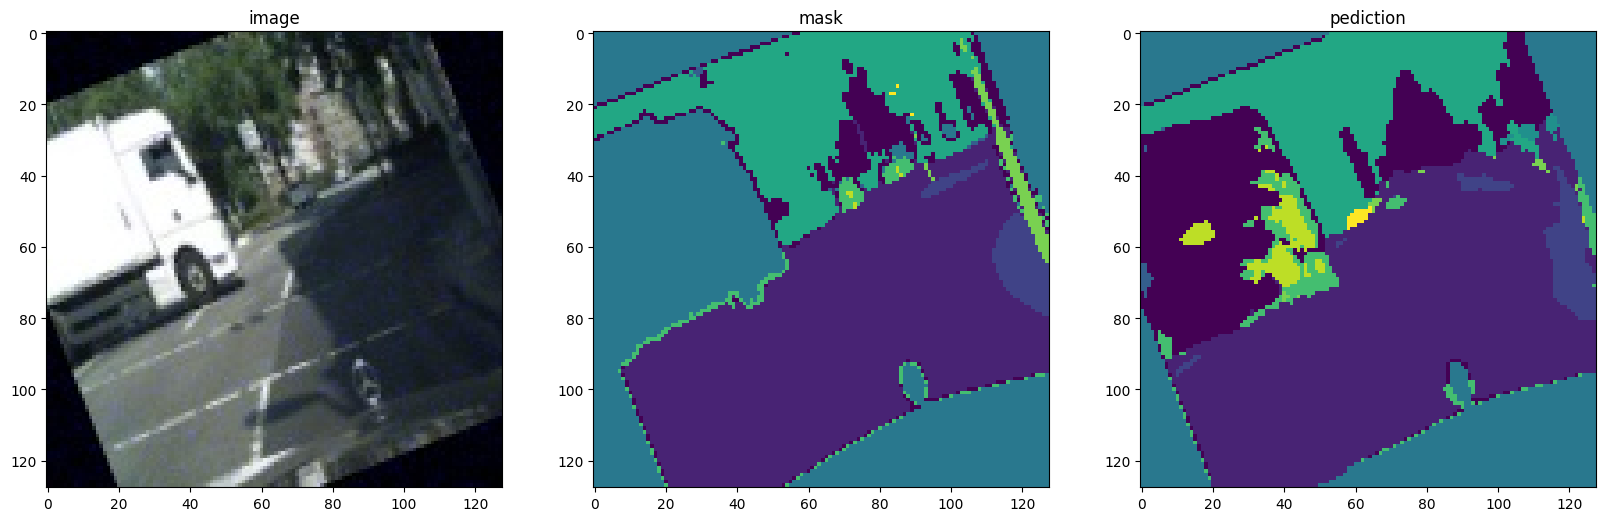

 93%|█████████▎| 14/15 [18:54<01:21, 81.02s/it]

[Epochs-14/15]:
[Train_loss:0.4324 | Train_acc:0.5269 | Val_loss:0.5157 | Val_acc:0.4740]
--------------------
Validation results after 15 epochs:


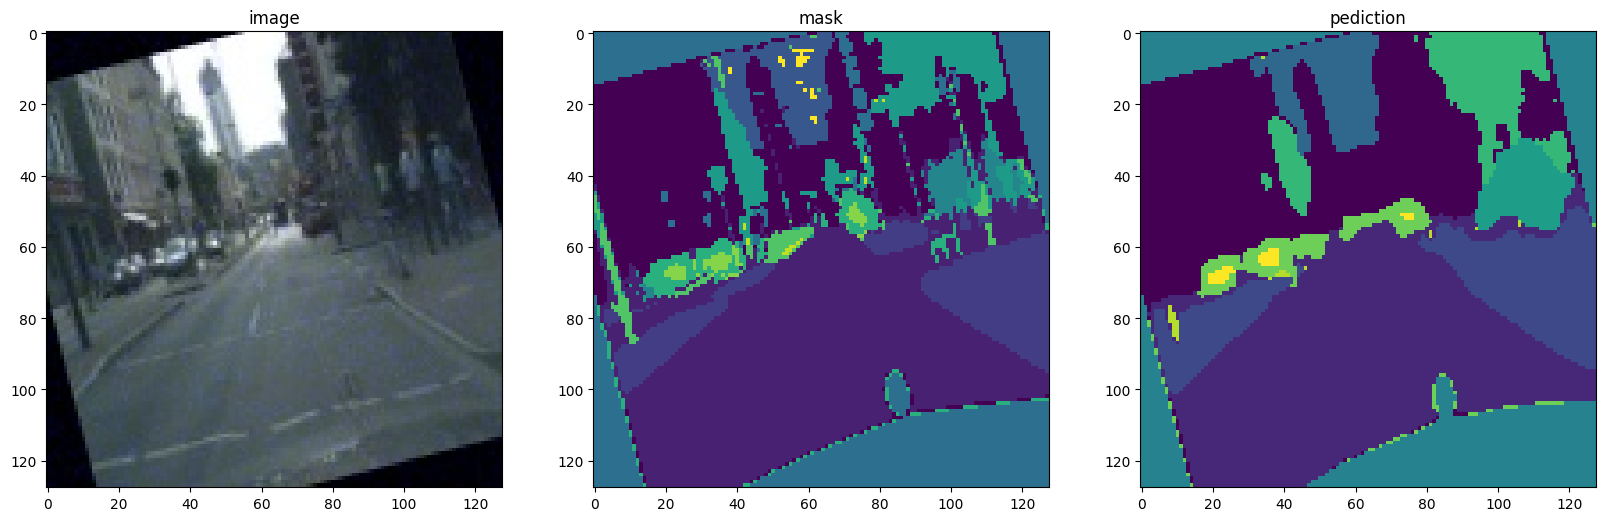

100%|██████████| 15/15 [20:15<00:00, 81.03s/it]

[Epochs-15/15]:
[Train_loss:0.4319 | Train_acc:0.5264 | Val_loss:0.5146 | Val_acc:0.4748]


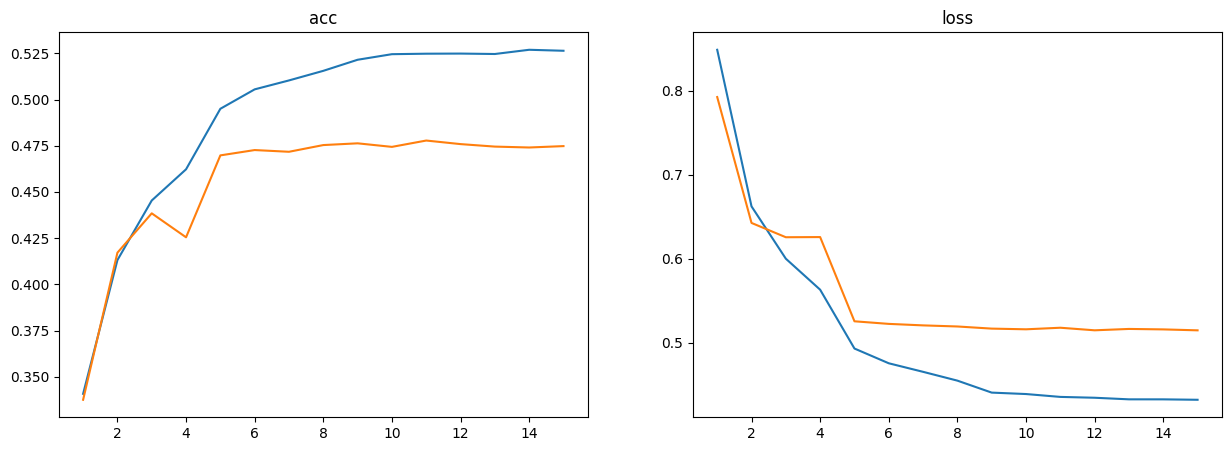

In [ ]:
trainer.train()

## Save model3

In [ ]:
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/b21ai056_mini_proj_3/Model_3.pth")

## Testing model3 on regular dataset, modified dataset1 and modified dataset2

In [ ]:
# Create an instance of your model3 class
model3 = Net(num_classes=OUTPUT_CLASSES)

# Load the model3 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_3.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model3
model3.load_state_dict(new_state_dict)

# Set the model3 to evaluation mode
model3.eval()


validator = Validator(model3, val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)


Validation Accuracy: 0.34140756038819225


In [ ]:
# new_val_data_obj = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)
validator = Validator(model3, new_val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.16793623278171838


In [ ]:
# val_data_obj1 = Dataset(test_files, test_files_mask, INPUT_IMG_SIZE,augmentation=True, apply_noise=True, mean=MEAN, std=STD)
validator = Validator(model3, val_data_obj1, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.4884124349245101


## Ensemble Model of Model1, 2 and 3

In [ ]:
class ensemble_validator:
    def __init__(self, models, val_data, criterion, use_cuda=False):
        self.models = models
        self.val_data = val_data
        self.criterion = criterion
        self.cuda = use_cuda

        if use_cuda:
          for model in self.models:
            model = model.cuda()

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size=8, shuffle=False)  # Batch size 1 for validation


    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        # pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)

        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def validate(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        for model in self.models:
          model.eval()
        acc_list = []

        with torch.no_grad():
            val_dl = self.data_loader(self.val_data)

            for i, (images, labels) in enumerate(val_dl):
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                pred_list = []
                for model in self.models:
                  pred_list.append(model(images).detach().cpu())
                preds = pred_list[0]
                for p in range(1,len(pred_list)):
                  preds+=pred_list[p]
                preds = preds/len(pred_list)
                accuracy = self.IoU(labels, preds)
                acc_list.append(accuracy)

        acc_avg = np.mean(acc_list)
        return acc_avg



In [ ]:
model1 = Net(num_classes=OUTPUT_CLASSES)

# Load the model1 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_1.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model1
model1.load_state_dict(new_state_dict)

model2 = Net(num_classes=OUTPUT_CLASSES)

# Load the model2 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_2.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model2
model2.load_state_dict(new_state_dict)

model3 = Net(num_classes=OUTPUT_CLASSES)

# Load the model3 state dictionary, ignore "module" prefixes if present
state_dict = torch.load("/content/drive/MyDrive/b21ai056_mini_proj_3/Model_3.pth")
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

# Load the modified state dictionary into the model3
model3.load_state_dict(new_state_dict)

<All keys matched successfully>

## Testing Ensemble Model on regular dataset, modified dataset1 and modified dataset2

In [ ]:
validator = ensemble_validator([model1,model2,model3], val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.4533165164996935


In [ ]:
validator = ensemble_validator([model1,model2,model3], new_val_data_obj, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.3051226466475398


In [ ]:
validator = ensemble_validator([model1,model2,model3], val_data_obj1, loss_function, use_cuda=True)
validation_accuracy = validator.validate()

print('Validation Accuracy:', validation_accuracy)

Validation Accuracy: 0.42101416996319474


## Deployment

In [ ]:
import random

import streamlit as st
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import io
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import from_numpy


class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X)

        contracting_12_out = self.contracting_12(contracting_11_out)

        contracting_21_out = self.contracting_21(contracting_12_out)

        contracting_22_out = self.contracting_22(contracting_21_out)

        contracting_31_out = self.contracting_31(contracting_22_out)

        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)

        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))

        expansive_21_out = self.expansive_21(expansive_12_out)

        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))

        expansive_31_out = self.expansive_31(expansive_22_out)

        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out


# Function to perform image segmentation
def segment_image(input_image):
    # Load the input image
    image = Image.open(io.BytesIO(input_image)).convert('RGB')
    # image = np.array(image)

    # Perform image segmentation using your model
    # Replace 'segmentation_function' with your actual segmentation code
    model1 = Net(num_classes=12)
    model2 = Net(num_classes=12)
    model3 = Net(num_classes=12)

    segmentation_model_path1 = "Model_1.pth"
    segmentation_model_path2 = "Model_2.pth"
    segmentation_model_path3 = "Model_3.pth"

    if torch.cuda.is_available():
        state_dict1 = torch.load(segmentation_model_path1)
        state_dict1 = {key.replace("module.", ""): value for key, value in state_dict1.items()}
        model1.load_state_dict(state_dict1)

        state_dict2 = torch.load(segmentation_model_path2)
        state_dict2 = {key.replace("module.", ""): value for key, value in state_dict2.items()}
        model2.load_state_dict(state_dict2)

        state_dict3 = torch.load(segmentation_model_path3)
        state_dict3 = {key.replace("module.", ""): value for key, value in state_dict3.items()}
        model3.load_state_dict(state_dict3)
    else:
        state_dict1 = torch.load(segmentation_model_path1, map_location=torch.device('cpu'))
        state_dict1 = {key.replace("module.", ""): value for key, value in state_dict1.items()}
        model1.load_state_dict(state_dict1)

        state_dict2 = torch.load(segmentation_model_path2, map_location=torch.device('cpu'))
        state_dict2 = {key.replace("module.", ""): value for key, value in state_dict2.items()}
        model2.load_state_dict(state_dict2)

        state_dict3 = torch.load(segmentation_model_path3, map_location=torch.device('cpu'))
        state_dict3 = {key.replace("module.", ""): value for key, value in state_dict3.items()}
        model3.load_state_dict(state_dict3)
    h, w = 128, 128
    mean = [0., 0., 0.]
    std = [1., 1., 1.]
    test_transformer = transforms.Compose([
        transforms.Resize((h, w)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    image = test_transformer(image).unsqueeze(0)
    #  image = from_numpy(image).permute(2, 0, 1)
    pred1 = model1(image)
    pred2 = model2(image)
    pred3 = model3(image)

    segmented_image1 = pred1[0].permute(1, 2, 0)
    segmented_image1 = torch.argmax(segmented_image1, dim=2).cpu()

    segmented_image2 = pred2[0].permute(1, 2, 0)
    segmented_image2 = torch.argmax(segmented_image2, dim=2).cpu()

    segmented_image3 = pred3[0].permute(1, 2, 0)
    segmented_image3 = torch.argmax(segmented_image3, dim=2).cpu()

    segmented_image4 = (segmented_image1 + segmented_image2 + segmented_image3) / 3
    # segmented_image = Image.fromarray(segmented_image)
    # Create a matplotlib figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    plt.title("Segmented Images")
    # Display segmented_image1
    axes[0, 0].imshow(segmented_image1, aspect='equal')
    axes[0, 0].set_title('From Model 1')
    axes[0, 0].axis('off')

    # Display segmented_image2
    axes[0, 1].imshow(segmented_image2, aspect='equal')
    axes[0, 1].set_title('From Model 2')
    axes[0, 1].axis('off')

    # Display segmented_image3
    axes[1, 0].imshow(segmented_image3, aspect='equal')
    axes[1, 0].set_title('From Model 3')
    axes[1, 0].axis('off')

    # Display segmented_image4
    axes[1, 1].imshow(segmented_image4, aspect='equal')
    axes[1, 1].set_title('Ensemble Model')
    axes[1, 1].axis('off')

    st.pyplot(fig)
    # return segmented_image


# Streamlit App
st.title('Image Segmentation App')

# Upload an image
uploaded_image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_image is not None:
    st.image(uploaded_image, caption='Uploaded Image', use_column_width=True)

    # Perform segmentation when a button is clicked
    if st.button('Segment Image'):
        with st.spinner('Segmenting...'):
            # Call the segment_image function with the uploaded image
            segment_image(uploaded_image.getvalue())
